# Semantic segmentation of unexpected objects on roads

## Setup

In [1]:
SEED = 42

DATA_DIR = "./data"
ANOMALY_DATA_DIR = "./data_voc" # Path to Pascal VOC. It will be downloaded if it does not exist (more details in Section 2)
CHECKPOINTS_DIR = "./weights"

# If True, pre-fitted sklearn models will be used.
LOAD_PREFITTED = True

# The following flags determine what to run from scratch.
# If set to False, pre-computed results will be loaded.
RUN_DATA_EXPLORATION = False    # Data exploration in Section 2.
RUN_TUNING = False              # Hyperparameter tuning in Section 3.
RUN_EVALUATION = False          # Model evaluation in Section 4.
RUN_ABLATION = False            # Ablation study in Section 5.

In [2]:
# Dataset download (if needed)
!mkdir -p $DATA_DIR
!test ! -d $DATA_DIR/train \
    && wget -O $DATA_DIR/train.tar https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar \
    && tar -xf $DATA_DIR/train.tar -C $DATA_DIR
!test ! -d $DATA_DIR/test \
    && wget -O $DATA_DIR/test.tar https://people.eecs.berkeley.edu/~hendrycks/streethazards_test.tar \
    && tar -xf $DATA_DIR/test.tar -C $DATA_DIR

In [ ]:
!pip install lightning fast_slic

In [3]:
import os
from pathlib import Path
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.utils.data import DataLoader
import lightning as L

from typing import Union, Optional


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


DEEPLABV3_MOBILE_VIT_S_MAIN_DIR             = os.path.join(CHECKPOINTS_DIR, "deeplabv3-mobilevit-small/wd01_no-weighted_resize")
DEEPLABV3_MOBILE_VIT_S_ABL_NO_DECAY_DIR     = os.path.join(CHECKPOINTS_DIR, "deeplabv3-mobilevit-small/wd00_no-weighted_resize")
DEEPLABV3_MOBILE_VIT_S_ABL_LOWER_DECAY_DIR  = os.path.join(CHECKPOINTS_DIR, "deeplabv3-mobilevit-small/wd001_no-weighted_resize")
DEEPLABV3_MOBILE_VIT_S_ABL_HIGHER_DECAY_DIR = os.path.join(CHECKPOINTS_DIR, "deeplabv3-mobilevit-small/wd02_no-weighted_resize")
DEEPLABV3_MOBILE_VIT_S_ABL_WEIGHTED_DIR     = os.path.join(CHECKPOINTS_DIR, "deeplabv3-mobilevit-small/wd01_weighted_resize")
DEEPLABV3_MOBILE_VIT_S_ABL_CROP_DIR         = os.path.join(CHECKPOINTS_DIR, "deeplabv3-mobilevit-small/wd01_no-weighted_crop")
DEEPLABV3_MOBILE_VIT_XS_ABL_DIR             = os.path.join(CHECKPOINTS_DIR, "deeplabv3-mobilevit-x-small")
DEEPLABV3_MOBILENET_ABL_DIR                 = os.path.join(CHECKPOINTS_DIR, "deeplabv3-mobilenet")

DATA_TRAIN_ODGT = os.path.join(DATA_DIR, "train/train.odgt")
DATA_VAL_ODGT   = os.path.join(DATA_DIR, "train/validation.odgt")
DATA_TEST_ODGT  = os.path.join(DATA_DIR, "test/test.odgt")

assert all([ 
    Path(path).exists() for path in [
        DEEPLABV3_MOBILE_VIT_S_MAIN_DIR,
        DEEPLABV3_MOBILE_VIT_S_ABL_LOWER_DECAY_DIR,
        DEEPLABV3_MOBILE_VIT_S_ABL_HIGHER_DECAY_DIR,
        DEEPLABV3_MOBILE_VIT_S_ABL_WEIGHTED_DIR,
        DEEPLABV3_MOBILE_VIT_S_ABL_CROP_DIR,
        DEEPLABV3_MOBILE_VIT_XS_ABL_DIR,
        DEEPLABV3_MOBILENET_ABL_DIR,
        DATA_TRAIN_ODGT,
        DATA_VAL_ODGT,
        DATA_TEST_ODGT
    ]
])


all_results = {
    "val": {},
    "val_anom": {},
    "test": {}
}

### External libraries copy-paste

In [4]:
#
# utils/street_hazards.py
#
import os
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms

from enum import IntEnum
from typing import Optional


class StreetHazardsClasses(IntEnum):
    UNLABELED       = 0
    BUILDING        = 1
    FENCE           = 2
    OTHER           = 3
    PEDESTRIAN      = 4
    POLE            = 5
    ROAD_LINE       = 6
    ROAD            = 7
    SIDEWALK        = 8
    VEGETATION      = 9
    CAR             = 10
    WALL            = 11
    TRAFFIC_SIGN    = 12
    ANOMALY         = 13


class StreetHazardsDataset(Dataset):
    def __init__(
        self,
        odgt_path: str,
        more_transforms1 = None,
        more_transforms2 = None,
        random_crop_size: Optional[tuple[int, int]] = None,
        add_random_anomalies: bool = False,
        anomaly_dataset_path: str = "./data_voc"
    ):
        with open(odgt_path, "r") as f:
            odgt_data = json.load(f)

        self.paths = [
            {
                "image": os.path.join(Path(odgt_path).parent, data["fpath_img"]),
                "annotation": os.path.join(Path(odgt_path).parent, data["fpath_segm"]),
            }
            for data in odgt_data 
        ]
        
        self.to_tensor_transform = transforms.ToTensor()
        self.more_transforms1 = more_transforms1 if more_transforms1 is not None else (lambda x: x)
        self.more_transforms2 = more_transforms2 if more_transforms2 is not None else (lambda x: x)

        self.random_crop_size = random_crop_size

        self.add_random_anomalies = add_random_anomalies
        if self.add_random_anomalies:
            try:
                self.ds_anomaly = torchvision.datasets.VOCSegmentation(anomaly_dataset_path, image_set="val")
            except:
                self.ds_anomaly = torchvision.datasets.VOCSegmentation(anomaly_dataset_path, image_set="val", download=True)

    def __getitem__(self, idx):
        image = Image.open(self.paths[idx]["image"]).convert("RGB")
        annotation = Image.open(self.paths[idx]["annotation"])

        # Apply transforms
        image = self.to_tensor_transform(image)
        image = self.more_transforms1(image)
        annotation = torch.as_tensor(transforms.functional.pil_to_tensor(annotation), dtype=torch.int64) - 1 # Make class indexes start from 0
        annotation = self.more_transforms2(annotation).squeeze(0)

        # Apply same random crop on image and annotation
        if self.random_crop_size is not None:
            i, j, h, w = transforms.RandomCrop.get_params(image, output_size=self.random_crop_size)
            image = transforms.functional.crop(image, i, j, h, w)
            annotation = transforms.functional.crop(annotation, i, j, h, w)
        
        # Add random anomaly
        if self.add_random_anomalies:
            for i in range(np.random.randint(1, 4)):
                # Determine position of the anomaly
                anomaly_size = (np.random.randint(image.shape[1]*0.1, image.shape[1]*0.3), np.random.randint(image.shape[2]*0.1, image.shape[2]*0.3))
                i, j, h, w = transforms.RandomCrop.get_params(image, output_size=anomaly_size)

                # Choose random image from Pascal VOC
                possible_classes = []
                while len(possible_classes) == 0: # In some cases there are no classes available
                    anomaly_idx = np.random.randint(0, len(self.ds_anomaly))
                    anomaly_image = self.to_tensor_transform(self.ds_anomaly[anomaly_idx][0])
                    anomaly_annot = torch.from_numpy(np.array(self.ds_anomaly[anomaly_idx][1])).unsqueeze(0)
                    possible_classes = np.unique(anomaly_annot)[1:-1] # Ignore 0 and 255

                # Select random class in chosen image and resize to the resolution of the crop
                anomaly_class = np.random.choice(possible_classes)
                anomaly_image = F.interpolate(anomaly_image.unsqueeze(0), size=(h, w), mode="bilinear").squeeze(0)
                anomaly_annot = F.interpolate(anomaly_annot.unsqueeze(0), size=(h, w), mode="nearest").squeeze((0, 1))

                # Insert anomaly
                image[:, i:i+h, j:j+w][:, anomaly_annot == anomaly_class] = anomaly_image[:, anomaly_annot == anomaly_class]
                annotation[i:i+h, j:j+w][anomaly_annot == anomaly_class] = StreetHazardsClasses.ANOMALY

        return image, annotation

    def __len__(self):
        return len(self.paths)
    

COLORS = np.array([
    [  0,   0,   0],  # unlabeled    =   0,
    [ 70,  70,  70],  # building     =   1,
    [190, 153, 153],  # fence        =   2, 
    [250, 170, 160],  # other        =   3,
    [220,  20,  60],  # pedestrian   =   4, 
    [153, 153, 153],  # pole         =   5,
    [157, 234,  50],  # road line    =   6, 
    [128,  64, 128],  # road         =   7,
    [244,  35, 232],  # sidewalk     =   8,
    [107, 142,  35],  # vegetation   =   9, 
    [  0,   0, 142],  # car          =  10,
    [102, 102, 156],  # wall         =  11, 
    [220, 220,   0],  # traffic sign =  12,
    [ 60, 250, 240],  # anomaly      =  13,
])

def visualize_annotation(annotation_img: np.ndarray|torch.Tensor, ax=None):
    """
    Adapted from https://github.com/CVLAB-Unibo/ml4cv-assignment/blob/master/utils/visualize.py
    """
    if ax is None: ax = plt.gca()
    annotation_img = np.asarray(annotation_img)
    img_new = np.zeros((*annotation_img.shape, 3))

    for index, color in enumerate(COLORS):
        img_new[annotation_img == index] = color

    ax.imshow(img_new / 255.0)
    ax.set_xticks([])
    ax.set_yticks([])

def visualize_scene(image: np.ndarray|torch.Tensor, ax=None):
    if ax is None: ax = plt.gca()
    image = np.asarray(image)
    ax.imshow(np.moveaxis(image, 0, -1))
    ax.set_xticks([])
    ax.set_yticks([])

def visualize_anomaly(anomaly_map: np.ndarray|torch.Tensor, alpha=1, ax=None, colorbar=False):
    if ax is None: ax = plt.gca()
    im = ax.imshow(anomaly_map, alpha=alpha, cmap="turbo")
    ax.set_xticks([])
    ax.set_yticks([])

    if colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)        
        plt.gcf().colorbar(im, cax=cax, orientation="vertical")

def show_results(image, labels, segm_preds, anomaly_map, figsize=(18, 2), title=""):
    plt.figure(figsize=figsize)
    plt.suptitle(title)
    plt.subplot(1, 5, 1)
    visualize_scene(image)
    plt.subplot(1, 5, 2)
    visualize_annotation(labels)
    plt.subplot(1, 5, 3)
    visualize_annotation(segm_preds)
    plt.subplot(1, 5, 4)
    visualize_scene(image)
    visualize_anomaly(anomaly_map, alpha=0.6)
    plt.subplot(1, 5, 5)
    visualize_anomaly(anomaly_map, colorbar=True)
    plt.show()


#
# models/utils/BaseSegmenterAndDetector.py
#
import torch

class BaseSegmenterAndDetector:
    def __init__(self):
        super().__init__()

        
    def forward(self, inputs: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns:
            segmentation (torch.Tensor): (B x C x H x W) tensor with the raw predictions for segmentation.
            anomaly (torch.Tensor): (B x 1 x H x W) tensor with the raw predictions for anomaly.
        """
        raise NotImplementedError()
    

#
# utils/predictor.py
#
import numpy as np
try:
    from fast_slic.avx2 import SlicAvx2 as Slic
except:
    from fast_slic import Slic
import torch


class BasePredictor:
    def __init__(self, model: BaseSegmenterAndDetector):
        super().__init__()
        self.model = model.eval()

    def to(self, device):
        self.model.to(device)

    def forward(inputs: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns:
            segmentation_map (torch.Tensor): Shape H x W
            anomaly_predicitions (torch.Tensor): Shape H x W
        """
        raise NotImplementedError()

    def __call__(self, inputs: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        segm_preds, ood_scores = self.forward(inputs)
        return segm_preds, ood_scores
    

class StandardPredictor(BasePredictor):
    def __init__(self, model: BaseSegmenterAndDetector):
        """
        Predictor that applies argmax on segmentation logits and leaves OOD scores as-is.
        """
        super().__init__(model)

    @torch.no_grad()
    def forward(self, inputs):
        segm_logits, ood_scores = self.model(inputs)
        return torch.argmax(segm_logits, dim=1), ood_scores.squeeze(1)


def _prepare_image_for_slic(image):
    image = np.moveaxis(image.numpy(), 0, -1) # H x W x C
    image = (image*255).astype(np.uint8)
    image = np.ascontiguousarray(image)
    return image

class SuperpixelPredictor(BasePredictor):
    def __init__(self, 
            model: BaseSegmenterAndDetector, 
            apply_on_segmentation = False, 
            apply_on_anomaly = True, 
            slic_num_components = 200, 
            slic_compactness = 20,
        ):
        super().__init__(model)
        assert apply_on_segmentation or apply_on_anomaly, "Nothing to segment"
        self.apply_on_segmentation = apply_on_segmentation
        self.apply_on_anomaly = apply_on_anomaly
        self.slic_num_components = slic_num_components
        self.slic_compactness = slic_compactness
    

    @torch.no_grad()
    def forward(self, inputs):
        slic = Slic(num_components=self.slic_num_components, compactness=self.slic_compactness) # Must be recreated every time for determinism
        segm_logits, ood_scores = self.model(inputs)
        segm_maps = torch.argmax(segm_logits, dim=1)
        ood_scores = ood_scores.squeeze(1)

        for i in range(len(inputs)):
            segments = slic.iterate(_prepare_image_for_slic(inputs[i].cpu()))

            for j in np.unique(segments):
                if self.apply_on_segmentation:
                    # The segmentation class of a superpixel is the most frequent class within it
                    segm_maps[i, segments == j] = segm_maps[i, segments == j].mode().values
                if self.apply_on_anomaly:
                    # The anomaly score of a superpixel is the average of the scores within it
                    ood_scores[i, segments == j] = ood_scores[i, segments == j].mean()

        return segm_maps, ood_scores




#
# utils/eval.py
#
import numpy as np
from tqdm.auto import tqdm

import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import average_precision_score


class AccumulatorMIoU:
    """
    Accumulates a confusion matrix and computes mIoU when needed.
    Adapted from https://github.com/VainF/DeepLabV3Plus-Pytorch/blob/master/metrics/stream_metrics.py
    """
    def __init__(self, num_classes, anomaly_index):
        self.num_classes = num_classes
        self.anomaly_index = anomaly_index if anomaly_index is not None else -1
        self.reset()

    def _fast_hist(self, preds, labels):
        mask = (labels >= 0) & (labels != self.anomaly_index)
        hist = np.bincount(
            self.num_classes * labels[mask].type(torch.int32) + preds[mask],
            minlength = self.num_classes ** 2,
        ).reshape(self.num_classes, self.num_classes)
        return hist
    
    def add(self, preds, labels):
        if preds.dim() == 2: preds = preds.unsqueeze(0)
        if labels.dim() == 2: labels = labels.unsqueeze(0)
        preds, labels = preds.cpu(), labels.cpu()
        for p, l in zip(preds, labels):
            self.confusion_matrix += self._fast_hist( p.flatten(), l.flatten() )

    def compute(self, return_classwise_iou=False):
        hist = self.confusion_matrix
        with np.errstate(divide="ignore", invalid="ignore"):
            iou_c = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iou = np.nanmean(iou_c)
        return (mean_iou, iou_c.tolist()) if return_classwise_iou else mean_iou
    
    def reset(self):
        self.confusion_matrix = np.zeros((self.num_classes, self.num_classes))


class AccumulatorAUPR:
    def __init__(self):
        """
        Accumulates AUPRs and averages them when needed.
        """
        self.reset()

    def add(self, preds, labels):
        if preds.dim() == 2: preds = preds.unsqueeze(0)
        if labels.dim() == 2: labels = labels.unsqueeze(0)
        preds, labels = preds.cpu(), labels.cpu()
        for p, l in zip(preds, labels):
            self.aupr_accumulator += average_precision_score(l.type(torch.int32).flatten().numpy(), p.type(torch.float32).flatten().numpy())
            self.auprs_count += 1

    def compute(self):
        return self.aupr_accumulator / self.auprs_count
    
    def reset(self):
        self.aupr_accumulator = 0
        self.auprs_count = 0


@torch.no_grad()
def evaluate_model(
        predictor: BasePredictor,
        ds: Dataset, 
        tot_classes = len(StreetHazardsClasses), 
        anomaly_class = StreetHazardsClasses.ANOMALY,
        batch_size = 1, 
        compute_miou = True, 
        compute_ap = True, 
        device = "cuda", 
    ):
    """
    Evaluates a predictor on a dataset.
    """
    assert compute_miou or compute_ap, "Requested to compute nothing"
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False)
    predictor.to(device)
    miou_acc = AccumulatorMIoU(tot_classes-1, anomaly_class) if compute_miou else None
    aupr_acc = AccumulatorAUPR() if compute_ap else None

    for inputs, labels in (pbar := tqdm(dl)):
        inputs = inputs.to(device)
        labels = labels.cpu()

        segm_maps, anom_preds = predictor(inputs)
        segm_maps, anom_preds = segm_maps.cpu(), anom_preds.cpu()

        for i in range(len(inputs)):
            if compute_miou:
                miou_acc.add(segm_maps[i], labels[i])
            if compute_ap:
                aupr_acc.add(anom_preds[i], (labels[i] == anomaly_class))

        pbar.set_description(f"mIoU: {miou_acc.compute()*100 if compute_miou else 0:.2f} -- AUPR: {aupr_acc.compute()*100 if compute_ap else 0:.2f}")

    out = {}
    if compute_miou:
        miou, iou_c = miou_acc.compute(return_classwise_iou=True)
        out["miou"] = miou
        out["iou_c"] = iou_c
    if compute_ap:
        out["ap"] = aupr_acc.compute()
    return out



#
# models/utils/PretrainedSegmenter.py
#
import torch
import torch.nn.functional as F
import lightning as L
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, deeplabv3_resnet50
import transformers
from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation
from typing import Optional, Union, Literal


class PretrainedSegmenter(L.LightningModule):
    def __init__(self, 
        optimizer_args: dict, 
        image_size: Optional[tuple[int, int]], 
        num_classes: int, 
        class_weights: Optional[torch.Tensor],
        multi_label: bool
    ):
        """
        Unified interface for PyTorch and (some) Hugging Face models for segmentation.
        Note: a model should be created using the static `get` method.
        """
        super().__init__()
        self.model = None
        self.image_size = image_size
        self.num_classes = num_classes
        self.class_weights = class_weights if class_weights is not None else torch.ones(num_classes)
        self.multi_label = multi_label
        self.optimizer_args = optimizer_args
        self.train_miou_acc = AccumulatorMIoU(num_classes, None)
        self.val_miou_acc = AccumulatorMIoU(num_classes, None)


    def _forward(self, images) -> tuple[torch.Tensor, Optional[list[torch.Tensor]]]:
        """
        Returns:
            logits
            hidden_states (if any)
        """
        raise NotImplementedError()


    def forward(self, images, return_hidden_states=False):
        if self.image_size:
            # Resize to model input size
            original_shape = (images.shape[2], images.shape[3])
            images = F.interpolate(images, self.image_size, mode="bilinear")

        logits, hidden_states = self._forward(images)

        if self.image_size:
            # Restore original resolution
            logits = F.interpolate(logits, original_shape, mode="bilinear")

        return (logits, hidden_states) if return_hidden_states else logits


    def get_hidden_sizes(self):
        raise NotImplementedError()
    

    @staticmethod
    def get(
        model_name: Union[Literal["deeplabv3_mobilenet", "deeplabv3_resnet50"], str], 
        optimizer_args: dict = {}, 
        image_size: Optional[tuple[int, int]] = None, 
        num_classes: int = len(StreetHazardsClasses)-1,
        class_weights: Optional[torch.Tensor] = None,
        multi_label: bool = False
    ):
        """
        Creates a segmentation model given a configuration.
        """
        match model_name:
            case "deeplabv3_mobilenet":
                return _PretrainedPytorchSegmenter(model_name, optimizer_args, image_size, num_classes, class_weights, multi_label)
            case "deeplabv3_resnet50":
                return _PretrainedPytorchSegmenter(model_name, optimizer_args, image_size, num_classes, class_weights, multi_label)
            case _:
                return _PretrainedHuggingFaceSegmenter(model_name, optimizer_args, image_size, num_classes, class_weights, multi_label)


    # Lightning stuff

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), **self.optimizer_args)
        return optimizer

    def __loss(self, logits, labels):
        if self.multi_label:
            loss = 0
            for c in range(self.num_classes):
                loss += F.binary_cross_entropy_with_logits(logits[:, c], (labels == c).type(torch.float32))
            return loss
        else:
            return F.cross_entropy(logits, labels, weight=self.class_weights.to(self.device))

    def training_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.__loss(logits, labels)

        self.train_miou_acc.add(torch.argmax(logits, dim=1), labels)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.__loss(logits, labels)

        self.val_miou_acc.add(torch.argmax(logits, dim=1), labels)
        self.log("val_loss", loss)
        return loss

    def on_train_epoch_end(self):
        self.log("train_miou", self.train_miou_acc.compute())
        self.log("val_miou", self.val_miou_acc.compute())
        metrics = self.trainer.callback_metrics

        print(
            f"Epoch {self.current_epoch} --- train_loss: {metrics['train_loss'].item():.4f} -- val_loss: {metrics['val_loss'].item():.4f}"
            f" | train_miou: {metrics['train_miou'].item():.4f} -- val_miou: {metrics['val_miou'].item():.4f}"
        )

        self.train_miou_acc.reset()
        self.val_miou_acc.reset()



class _PretrainedPytorchSegmenter(PretrainedSegmenter):
    def __init__(self, model_name, optimizer_args, image_size, num_classes, class_weights, multi_label):
        super().__init__(optimizer_args, image_size, num_classes, class_weights, multi_label)
        self.model_name = model_name
        match model_name:
            case "deeplabv3_mobilenet":
                self.model = deeplabv3_mobilenet_v3_large(num_classes=num_classes)
            case "deeplabv3_resnet50":
                self.model = deeplabv3_resnet50(num_classes=num_classes)
            case _:
                raise NotImplementedError("Model not available")

    def _forward(self, images):
        embeddings = self.model.backbone(images)["out"]
        logits = self.model.classifier(embeddings)
        return logits, [embeddings]
        
    def get_hidden_sizes(self):
        match self.model_name:
            case "deeplabv3_mobilenet": return 960
            case "deeplabv3_resnet50": return 2048


class _PretrainedHuggingFaceSegmenter(PretrainedSegmenter):
    def __init__(self, model_name, optimizer_args, image_size, num_classes, class_weights, multi_label):
        super().__init__(optimizer_args, image_size, num_classes, class_weights, multi_label)
        transformers.utils.logging.set_verbosity_error() # Temporarily suppress warning for non-trained head
        self.processor = AutoImageProcessor.from_pretrained(model_name)
        self.model = AutoModelForSemanticSegmentation.from_pretrained(model_name, num_labels=num_classes, ignore_mismatched_sizes=True)
        self.image_size = (self.model.config.image_size, self.model.config.image_size)
        transformers.utils.logging.set_verbosity_warning()

    def _forward(self, images):
        inputs = self.processor(images=images, return_tensors="pt", do_resize=False, do_rescale=False).to(self.model.device)
        outputs = self.model(**inputs, output_hidden_states=True)
        logits = outputs.logits
        hidden_states = outputs.hidden_states

        return logits, hidden_states
        
    def get_hidden_sizes(self):
        return self.model.config.neck_hidden_sizes[:-1]


#
# models/max_logit.py
#
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
import pickle
    

class MaxLogitModel(BaseSegmenterAndDetector, torch.nn.Module):
    def __init__(self, segmenter: PretrainedSegmenter):
        """
        MaxLogit anomaly detector defined in "Scaling Out-of-Distribution Detection for Real-World Settings" <https://arxiv.org/abs/1911.11132>.
        """
        super().__init__()
        self.segmenter = segmenter.eval()
    
    @torch.no_grad()
    def forward(self, inputs: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        logits = self.segmenter(inputs.to(self.segmenter.device))
        ood_scores = -1 * torch.max(logits, dim=1).values
        return logits, ood_scores.unsqueeze(1)


class MaxSoftmaxModel(BaseSegmenterAndDetector, torch.nn.Module):
    def __init__(self, segmenter: PretrainedSegmenter):
        """
        Maximum softmax probability defined in "A Baseline for Detecting Misclassified and Out-of-Distribution Examples in Neural Networks" 
        <https://arxiv.org/abs/1610.02136>
        """
        super().__init__()
        self.segmenter = segmenter.eval()
    
    @torch.no_grad()
    def forward(self, inputs: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        logits = self.segmenter(inputs.to(self.segmenter.device))
        ood_scores = -1 * torch.max(F.softmax(logits, dim=1), dim=1).values
        return logits, ood_scores.unsqueeze(1)


class StandardizedMaxLogitModel(BaseSegmenterAndDetector, torch.nn.Module):
    def __init__(self, segmenter: PretrainedSegmenter):
        """
        Standardized MaxLogit anomaly detector defined in 
        "Standardized Max Logits: A Simple yet Effective Approach for Identifying Unexpected Road Obstacles in Urban-Scene Segmentation" 
        <https://arxiv.org/abs/2107.11264>.
        """
        super().__init__()
        self.segmenter = segmenter.eval()
    
    @torch.no_grad()
    def fit(self, dl_train: torch.utils.data.DataLoader):
        all_maxlogits = []
        all_preds = []

        for images, _ in tqdm(dl_train):
            logits = self.segmenter(images.to(self.segmenter.device))
            segm_preds = torch.argmax(logits, dim=1)

            # Keep track of all logits and predictions
            all_maxlogits.append(logits.cpu().max(dim=1).values)
            all_preds.append(segm_preds.cpu())

        all_maxlogits = torch.concat(all_maxlogits, dim=0)
        all_preds = torch.concat(all_preds, dim=0)

        # Compute means and variances for each class
        means = torch.zeros((self.segmenter.num_classes))
        variances = torch.zeros((self.segmenter.num_classes))
        for c in range(self.segmenter.num_classes):
            means[c] = all_maxlogits[all_preds == c].sum() / (all_preds == c).sum()
            variances[c] = ((all_maxlogits[all_preds == c] - means[c].unsqueeze(0))**2).sum() / (all_preds == c).sum()
        
        self.means = means
        self.variances = variances

    @torch.no_grad()
    def forward(self, inputs: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        logits = self.segmenter(inputs.to(self.segmenter.device))
        segm_preds = torch.argmax(logits, dim=1)
        self.means, self.variances = self.means.to(segm_preds.device), self.variances.to(segm_preds.device)
        
        ood_scores = -1 * (torch.max(logits, dim=1).values - self.means[segm_preds]) / torch.sqrt(self.variances[segm_preds])

        return logits, ood_scores.unsqueeze(1)
    
    def save(self, path):
        with open(path, "wb") as f:
            pickle.dump({
                "means": self.means.cpu().tolist(),
                "variances": self.variances.cpu().tolist()
            }, f)

    def load(self, path):
        with open(path, "rb") as f:
            fitted_data = pickle.load(f)
            self.means = torch.Tensor(fitted_data["means"])
            self.variances = torch.Tensor(fitted_data["variances"])


#
# models/knn.py
#
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
import pickle
from typing import Union


@torch.no_grad()
def extract_hidden_states(
        model: Union[PretrainedSegmenter], 
        dataloader: torch.utils.data.DataLoader, 
        hidden_states_index: int = -1
    ) -> torch.Tensor:
    """
    Extracts the embedding space of a model on a given dataloader.

    Args:
        model (Union[PretrainedSegmenter, ViTAutoencoder])
        dataloader (torch.utils.data.DataLoader)
        hidden_states_index (int): Index of the layer from which to extract the embeddings if more are available.

    Returns:
        embeddings (torch.Tensor): All the extracted embeddings in the shape num_emb x emb_size.
    """
    all_hidden_states = []
    model.eval()

    for images, _ in tqdm(dataloader):
        if isinstance(model, PretrainedSegmenter):
            _, hidden_states = model(images.to(model.device), return_hidden_states=True)
            embeddings = hidden_states[hidden_states_index]
        else:
            raise RuntimeError("Unsupported model")
        
        embeddings = embeddings.permute((0, 2, 3, 1)).flatten(start_dim=0, end_dim=2).cpu() # B*H_e*W_e x emb
        all_hidden_states.append(embeddings)

    return torch.concat(all_hidden_states, dim=0)


def sample_hidden_states(hidden_states: torch.Tensor, num_out: int, seed=42) -> torch.Tensor:
    """
    Randomly samples embeddings from a given stack of hidden states.

    Args:
        hidden_states (torch.Tensor): Hidden states of shape N x emb to sample from.
        num_out (int): Number of embeddings to sample.
        seed (int)
    
    Returns:
        embeddings (torch.Tensor): Sampled embeddings of shape num_out x emb.
    """
    return hidden_states[ np.random.default_rng(seed).integers(0, len(hidden_states), num_out) ]


def get_ood_scores(knn: NearestNeighbors, embeddings: torch.Tensor) -> torch.Tensor:
    """
    Computes the OOD scores for each embedding based on the average distance to the nearest neighbors.

    Args:
        knn (NearestNeighbors): Fittest k-NN model.
        embeddings (torch.Tensor): Embeddings to compute OOD scores for. The expected shape is B x emb x H x W.

    Returns:
        ood_scores (torch.Tensor): Anomaly scores of shape B x H x W.
    """
    embeddings = embeddings.permute((0, 2, 3, 1)) # B x H x W x emb
    batch_size, latent_h, latent_w = embeddings.shape[0], embeddings.shape[1], embeddings.shape[2]
    ood_scores = np.zeros((batch_size, latent_h, latent_w))

    for i in range(len(embeddings)):
        knn_queries = embeddings[i].flatten(start_dim=0, end_dim=1)         # HW x emb
        distances, _ = knn.kneighbors(knn_queries)                          # HW x n_neighbors
        ood_scores[i] = distances.mean(axis=1).reshape(latent_h, latent_w)  # H x W
    
    ood_scores = torch.from_numpy(ood_scores)
    return ood_scores


class KNNModel(BaseSegmenterAndDetector, torch.nn.Module):
    def __init__(self, segmenter: PretrainedSegmenter, n_neighbors: int=1, hidden_states_index: int=-1):
        """
        Base k-NN anomaly detector that uses the embedding space of a segmenter.
        """
        super().__init__()
        self.segmenter = segmenter.eval()
        self.hidden_states_index = hidden_states_index
        self.knn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)

    def fit(self, hidden_states: torch.Tensor):
        self.knn.fit(hidden_states.type(torch.float32))
        return self
    
    @torch.no_grad()
    def forward(self, inputs: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        logits, hidden_states = self.segmenter(inputs.to(self.segmenter.device), return_hidden_states=True)
        
        ood_scores = get_ood_scores(self.knn, hidden_states[self.hidden_states_index].cpu())
        ood_scores = F.interpolate(ood_scores.unsqueeze(1), (inputs.shape[2], inputs.shape[3]), mode="bilinear")

        return logits, ood_scores
    
    def save(self, path):
        with open(path, "wb") as f:
            pickle.dump(self.knn, f)

    def load(self, path):
        with open(path, "rb") as f:
            self.knn = pickle.load(f)


class KmeansModel(KNNModel):
    """
    K-NN anomaly detector for segmentation models that uses k-means to reduce the embeddings used by k-NN.
    """
    def __init__(self, segmenter: PretrainedSegmenter, num_clusters=2000, n_neighbors=1, hidden_states_index=-1, seed=42):
        super().__init__(segmenter, n_neighbors, hidden_states_index)
        self.kmeans = KMeans(n_clusters=num_clusters, random_state=seed)

    @torch.no_grad()
    def fit(self, hidden_states: torch.Tensor):
        self.kmeans.fit(hidden_states)
        self.knn.fit(self.kmeans.cluster_centers_.astype(np.float32)) # Fit k-NN with centroids.
        return self


#
# utils/misc.py
#
import lightning as L
from tqdm.auto import tqdm
import numpy as np
from torch.utils.data.dataset import Dataset, Subset


def dataset_subset(dataset: Dataset, num_samples: int, seed=42):
    """
    Returns a subset of a dataset sampled uniformly.
    """
    return Subset(
        dataset, 
        np.random.default_rng(seed).choice(range(len(dataset)), size=num_samples, replace=False)
    )

2025-01-29 19:10:19.926907: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-29 19:10:19.938721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-29 19:10:19.941992: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 19:10:19.951712: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-29 19:10:21.148809: W tensorflow/compiler/tf2

### Utilities

#### Plot

In [5]:
def plot_loss(df_logs: pd.DataFrame):
    """
    Plots training (by step and epoch) and validation (by epoch) loss.
    """
    df_train_step_loss = df_logs[["step", "train_loss"]][~df_logs["train_loss"].isna()]
    df_train_epoch_loss = df_logs.groupby(["epoch"]).agg({"step": "max", "train_loss": "mean"})[["step", "train_loss"]]
    df_val_epoch_loss = df_logs[["step", "val_loss"]][~df_logs["val_loss"].isna()]
    last_step_per_epoch = df_train_epoch_loss["step"]
    
    plt.plot(df_train_epoch_loss["step"], df_train_epoch_loss["train_loss"], label="Train loss (epoch)")
    plt.plot(df_val_epoch_loss["step"], df_val_epoch_loss["val_loss"], label="Val loss (epoch)")
    plt.plot(df_train_step_loss["step"], df_train_step_loss["train_loss"], "--", alpha=0.6, label="Train loss (step)")

    plt.xlabel("Step")
    plt.ylabel("Loss")
    sec = plt.gca().secondary_xaxis(location="top")
    sec.set_xticks(last_step_per_epoch, labels=range(len(last_step_per_epoch)))
    sec.set_xlabel("Epoch")
    plt.ylim(top=df_train_epoch_loss["train_loss"].max() * 1.1) # Ignore first steps of train loss as it is (usually) too large for visualization
    plt.legend()
    plt.grid()


def plot_miou(df_logs: pd.DataFrame):
    """
    Plots training and validation mIoU.
    """
    df_train_epoch_miou = df_logs[["epoch", "train_miou"]][~df_logs["train_miou"].isna()]
    df_val_epoch_miou = df_logs[["epoch", "val_miou"]][~df_logs["val_miou"].isna()]

    plt.plot(df_train_epoch_miou["epoch"], df_train_epoch_miou["train_miou"], label="Train mIoU (epoch)")
    plt.plot(df_val_epoch_miou["epoch"], df_val_epoch_miou["val_miou"], label="Val mIoU (epoch)")

    plt.ylabel("mIoU")
    plt.xlabel("Epoch")
    plt.xticks(df_train_epoch_miou["epoch"])
    plt.legend()
    plt.grid()


def plot_logs(df_logs):
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 2, 1)
    plot_loss(df_logs)
    plt.subplot(1, 2, 2)
    plot_miou(df_logs)
    plt.show()

#### Model loading

In [6]:
class PredictorContainer:
    def __init__(self, predictor, name):
        """
        Container for a predictor with a label.
        """
        self.predictor = predictor
        self.name = name

    def __call__(self, inputs):
        return self.predictor(inputs)
    

def load_segmenter(segmenter_card, ckp_path, args={}, device=DEVICE):
    """
    Loads a segmentation model from a checkpoint.
    """
    segmenter = PretrainedSegmenter.get(segmenter_card, **args).to(device)
    segmenter.load_state_dict(torch.load(os.path.join(ckp_path, "checkpoint.pt"), weights_only=True))
    return segmenter


"""
Anomaly detector loaders.
"""

def _loadMaxSoftmaxModel(segmenter):
    return MaxSoftmaxModel(segmenter)

def _loadMaxLogitModel(segmenter):
    return MaxLogitModel(segmenter)

def _loadStandardizedMaxLogitModel(segmenter, use_prefitted, ds_train, save_fitted=True, ckp_path="."):
    model_std_maxlogit = StandardizedMaxLogitModel(segmenter)
    if use_prefitted:
        model_std_maxlogit.load(os.path.join(ckp_path, "stdmaxlogit.pkl"))
    else:
        model_std_maxlogit.fit(DataLoader(dataset_subset(ds_train, 500, SEED), batch_size=10))
        if save_fitted: model_std_maxlogit.save(os.path.join(ckp_path, "stdmaxlogit.pkl"))
    return model_std_maxlogit

def _loadKNNModel(segmenter, use_prefitted, hidden_states, hidden_states_index=-1, save_fitted=True, ckp_path="."):
    model_knn = KNNModel(segmenter, hidden_states_index=hidden_states_index)
    if use_prefitted:
        model_knn.load(os.path.join(ckp_path, f"knn_2000_{hidden_states_index}.pkl"))
    else:
        model_knn.fit(sample_hidden_states(hidden_states, 2000, SEED))
        if save_fitted: model_knn.save(os.path.join(ckp_path, f"knn_2000_{hidden_states_index}.pkl"))
    return model_knn

def _loadKMeansModel(segmenter, use_prefitted, hidden_states, hidden_states_index=-1, save_fitted=True, ckp_path="."):
    model_kmeans = KmeansModel(segmenter, hidden_states_index=hidden_states_index)
    if use_prefitted:
        model_kmeans.load(os.path.join(ckp_path, f"kmeans_2000_{hidden_states_index}.pkl"))
    else:
        model_kmeans.fit(hidden_states)
        if save_fitted: model_kmeans.save(os.path.join(ckp_path, f"kmeans_2000_{hidden_states_index}.pkl"))
    return model_kmeans


def load_predictors(
        segmenter_card,
        segmenter_ckp_path,
        PredictorClass = SuperpixelPredictor,
        ds_train = None,
        use_prefitted = True,
        label = None,
        save_fitted = True,
        segmenter_args = {},
        hidden_states_index = -1,
        include: Optional[list] = None,
        device = DEVICE
    ):
    """
    Loads all anomaly detection configurations given a segmentation model.
    """
    segmenter = load_segmenter(segmenter_card, segmenter_ckp_path, segmenter_args, device)

    # Compute hidden states to fit k-NN or k-means, if needed
    hidden_states = None
    if (not use_prefitted) and ((include is None) or ("knn" in include) or ("kmeans" in include)):
        hidden_states = extract_hidden_states(segmenter, DataLoader(dataset_subset(ds_train, 500, SEED), batch_size=10), hidden_states_index)
    
    label = "" if label is None else f" ({label})"
    predictors = {}

    if (include is None) or ("maxsoftmax" in include):
        model_maxsoftmax = _loadMaxSoftmaxModel(segmenter)
        predictors["maxsoftmax"] = PredictorContainer( PredictorClass(model_maxsoftmax), "Maximum softmax"+label )
    if (include is None) or ("maxlogit" in include):
        model_maxlogit = _loadMaxLogitModel(segmenter)
        predictors["maxlogit"] = PredictorContainer( PredictorClass(model_maxlogit), "MaxLogit"+label )
    if (include is None) or ("std_maxlogit" in include):
        model_std_maxlogit = _loadStandardizedMaxLogitModel(segmenter, use_prefitted, ds_train, save_fitted, segmenter_ckp_path)
        predictors["std_maxlogit"] = PredictorContainer( PredictorClass(model_std_maxlogit), "Standardized MaxLogit"+label )
    if (include is None) or ("knn" in include):
        model_knn = _loadKNNModel(segmenter, use_prefitted, hidden_states, hidden_states_index, save_fitted, segmenter_ckp_path)
        predictors["knn"] = PredictorContainer( PredictorClass(model_knn), "k-NN"+label )
    if (include is None) or ("kmeans" in include):
        model_kmeans = _loadKMeansModel(segmenter, use_prefitted, hidden_states, hidden_states_index, save_fitted, segmenter_ckp_path)
        predictors["kmeans"] = PredictorContainer( PredictorClass(model_kmeans), "k-means + k-NN"+label )

    return predictors

#### Evaluation

In [7]:
@torch.no_grad()
def evaluate_segmenter(model: Union[PredictorContainer, PretrainedSegmenter], dataset: torch.utils.data.Dataset, label="", device=DEVICE, seed=SEED):
    """
    Evaluate a single segmentation model.
    """
    if isinstance(model, PredictorContainer):
        predictor = model.predictor
    elif isinstance(model, PretrainedSegmenter):
        # To have a uniform interface, a Predictor is needed.
        # The segmentation model works the same for all anomaly detectors, so the choice here is not important.
        predictor = StandardPredictor(MaxLogitModel(model)) 
    L.seed_everything(seed, verbose=False)
    results = evaluate_model(predictor, dataset, device=device, compute_miou=True, compute_ap=False)
    return [{ "model": label, **results }]


@torch.no_grad()
def evaluate_predictor(predictor: BasePredictor, dataset: torch.utils.data.Dataset, label="", compute_miou=True, compute_ap=True, device=DEVICE, seed=SEED):
    """
    Evaluate a single predictor (segmentation + anomaly detection model).
    """
    L.seed_everything(seed, verbose=False)
    results = evaluate_model(predictor, dataset, device=device, compute_miou=compute_miou, compute_ap=compute_ap)
    return [{ "model": label, **results }]


@torch.no_grad()
def evaluate_predictors(
        predictors: Union[dict[PredictorContainer], list[PredictorContainer], PredictorContainer], 
        dataset: torch.utils.data.Dataset, 
        compute_miou = True, 
        compute_ap = True, 
        device = DEVICE
    ):
    """
    Evaluate a single or multiple predictors provided as PredictorContainer(s).
    """
    all_results = []
    if isinstance(predictors, PredictorContainer): predictors = [ predictors ]
    elif isinstance(predictors, dict): predictors = predictors.values()

    for config in predictors:
        all_results += evaluate_predictor(config.predictor, dataset, label=config.name, compute_miou=compute_miou, compute_ap=compute_ap, device=device)

    return all_results

#### Tabular results

In [8]:
def display_results(results: list[dict], caption=""):
    """
    Displays mIoU and AUPR.
    """
    df = pd.DataFrame.from_dict(results)
    if "miou" in df.columns: df["miou"] = df["miou"].apply(lambda x: f"{x*100:.2f}")
    if "ap" in df.columns: df["ap"] = df["ap"].apply(lambda x: f"{x*100:.2f}")
    df.drop(columns=df.columns.difference(["model", "miou", "ap"]), errors="ignore", inplace=True)
    df.rename(columns={"model": "Model", "miou": "mIoU", "ap": "AUPR"}, errors="ignore", inplace=True)
    df = df.style \
            .hide(axis="index") \
            .set_caption(caption)
    display(df)

def display_classwise_iou(results: list[dict], caption=""):
    """
    Displays IoU for each class.
    `results` should be from the same segmentation model.
    """
    iou_c = results[0]["iou_c"] # Results are all the same for the same segmentation model
    df = pd.DataFrame([iou_c], columns=[f"IoU_{c.name}" for c in StreetHazardsClasses if c != StreetHazardsClasses.ANOMALY])
    for c in df.columns:
        df[c] = df[c].apply(lambda x: f"{x*100:.2f}")
    df = df.style \
            .hide(axis="index") \
            .set_caption(caption)
    display(df)

---
---

## Table of contents<a id='toc0_'></a>    
  - [1. Introduction](#toc1_4_)    
    - [1.1. Overall approach](#toc1_4_1_)    
    - [1.2. Metrics and evaluation](#toc1_4_2_)    
    - [1.3. Notebook structure](#toc1_4_3_)    
  - [2. Dataset](#toc1_5_)    
    - [2.1. Anomalous validation set](#toc1_5_1_)    
    - [2.2. Data exploration](#toc1_5_2_)    
  - [3. Method](#toc1_6_)    
    - [3.1. Workflow](#toc1_6_1_)    
    - [3.2. Training details](#toc1_6_2_)    
      - [3.2.1. Segmentation model](#toc1_6_2_1_)    
      - [3.2.2. Anomaly detector](#toc1_6_2_2_)    
    - [3.3. Hyperparameter tuning](#toc1_6_3_)    
      - [3.3.1. Segmentation model training](#toc1_6_3_1_)    
        - [3.3.1.1. No weight decay](#toc1_6_3_1_1_)    
        - [3.3.1.2. Lower weight decay](#toc1_6_3_1_2_)    
        - [3.3.1.3. Higher weight decay](#toc1_6_3_1_3_)    
        - [3.3.1.4. Weighted loss](#toc1_6_3_1_4_)    
        - [3.3.1.5. Random crops](#toc1_6_3_1_5_)    
        - [3.3.1.6. Wrap-up and qualitative results](#toc1_6_3_1_6_)    
      - [3.3.2. Anomaly detector](#toc1_6_3_2_)    
        - [3.3.2.1. Number of neighbors](#toc1_6_3_2_1_)    
        - [3.3.2.2. Number of k-NN data points / Number of clusters](#toc1_6_3_2_2_)    
        - [3.3.2.3. Superpixel hyperparameters](#toc1_6_3_2_3_)    
  - [4. Results](#toc1_7_)    
    - [4.1. Quantitative results](#toc1_7_1_)    
    - [4.2. Qualitative results](#toc1_7_2_)    
      - [4.2.1. Closed-set segmentation](#toc1_7_2_1_)    
      - [4.2.2. Anomaly segmentation](#toc1_7_2_2_)    
  - [5. Ablation study](#toc1_8_)    
    - [5.1. Feature extractor](#toc1_8_1_)    
      - [5.1.1. Smaller model: DeepLabV3 + MobileViT-xsmall](#toc1_8_1_1_)    
      - [5.1.2. Bigger model: DeepLabV3 + MobileNet](#toc1_8_1_2_)    
      - [5.1.3. Qualitative results](#toc1_8_1_3_)    
    - [5.2. Anomaly detector](#toc1_8_2_)    
      - [5.2.1. Feature selection](#toc1_8_2_1_)    
      - [5.2.2. Superpixel segmentation](#toc1_8_2_2_)    
  - [6. Conclusion](#toc1_9_)    
    - [6.1. Discarded approaches](#toc1_9_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

---
## <a id='toc1_4_'></a>[1. Introduction](#toc0_)

### <a id='toc1_4_1_'></a>[1.1. Overall approach](#toc0_)

The approach chosen to solve the problem follows the idea of many proposals presented in the literature and consists of:
1. Training a model for closed-set semantic segmentation.
2. Adding the anomaly detector on top of the segmentation model.

For the segmentation task, the goal is to experiment with small models. The architecture of choice is DeepLabV3 with MobileViT-small as feature extractor (which has a pre-trained version on Hugging Face). This choice is to allow running more experiments which with a bigger architecture would not be possible due to the limited availability of computing resources. Moreover, most of the approaches proposed in the literature tend to use large networks, so having an idea of the capabilities of smaller ones can be useful. Finally, in a more practical point-of-view, a smaller model is also more portable and cheaper for real-time predictions, which is a reasonable requirement for this task.

For the anomaly detection module, the implemented approach uses as starting point the method based on nearest-neighbors proposed by [Galesso *et al.*](https://arxiv.org/abs/2211.06660v2) with some additional experiments with $k$-means to reduce the feature space. Moreover, with the goal of making predictions more aligned with the objects in the image, an additional step using superpixel segmentation with SLIC has been experimented with. 

### <a id='toc1_4_2_'></a>[1.2. Metrics and evaluation](#toc0_)

The required metrics are computed as follows:
- mIoU is computed using the implementation provided in the repository of [DeepLabV3+](https://github.com/VainF/DeepLabV3Plus-Pytorch/blob/master/metrics/stream_metrics.py) which accumulates a confusion matrix and computes the value after processing all the required samples (which is the definition given during the lectures). Other libraries that compute the average of individual mIoUs have been discarded.
- AUPR is computed using scikit-learn by averaging the `average_precision_score` of each individual sample.

To have some baselines, as in many other papers, the MaxLogit method proposed by [Hendrycks *et al.*](https://arxiv.org/abs/1911.11132) is used. In addition, the standardized MaxLogit method proposed by [Jung *et al.*](https://arxiv.org/abs/2107.11264) is also considered.

### <a id='toc1_4_3_'></a>[1.3. Notebook structure](#toc0_)
The next sections of the notebook are structured as follows:
- Section 2 presents some preliminary analysis on the dataset.
- Section 3 describes the pipeline, the training procedure, and motivates the choice of the hyperparameters.
- Section 4 shows the overall qualitative and quantitative results.
- Section 5 contains the results of ablation study.
- Section 6 concludes with some final remarks.

---
## <a id='toc1_5_'></a>[2. Dataset](#toc0_)

In [9]:
ds_train = StreetHazardsDataset(DATA_TRAIN_ODGT)
ds_val = StreetHazardsDataset(DATA_VAL_ODGT)
__ds_test = StreetHazardsDataset(DATA_TEST_ODGT)

### <a id='toc1_5_1_'></a>[2.1. Anomalous validation set](#toc0_)

As the available validation set only contains non-anomalous objects, it is not possible to tune hyperparameters without leaking the test set. Therefore, as is, training and tuning hyperparameters can only rely on the mIoU for the closed-set segmentation task.

In the literature, there are a few papers such as DenseHybrid proposed by [Grcić *et al.*](https://arxiv.org/abs/2207.02606v1) or RPL by [Liu *et al.*](https://arxiv.org/abs/2211.14512) that augment the training set by pasting external objects and considering them as anomalies. Taking some inspiration from this, a second validation set for tuning is created starting from the original one and by randomly pasting objects taken from PASCAL VOC. It is intuitive to observe that this new split is not representative of the real test set and it should be easier to solve as anomalies are more out of place. Nevertheless, this is the most straightforward way of creating some data for hyperparameter tuning.

In [10]:
ds_val_anomalies = StreetHazardsDataset(DATA_VAL_ODGT, add_random_anomalies=True, anomaly_dataset_path=ANOMALY_DATA_DIR)

### <a id='toc1_5_2_'></a>[2.2. Data exploration](#toc0_)

In [11]:
print(f"Training set size:   {len(ds_train)}")
print(f"Validation set size: {len(ds_val)}")
print(f"Test set size:       {len(__ds_test)}")

Training set size:   5125
Validation set size: 1031
Test set size:       1500


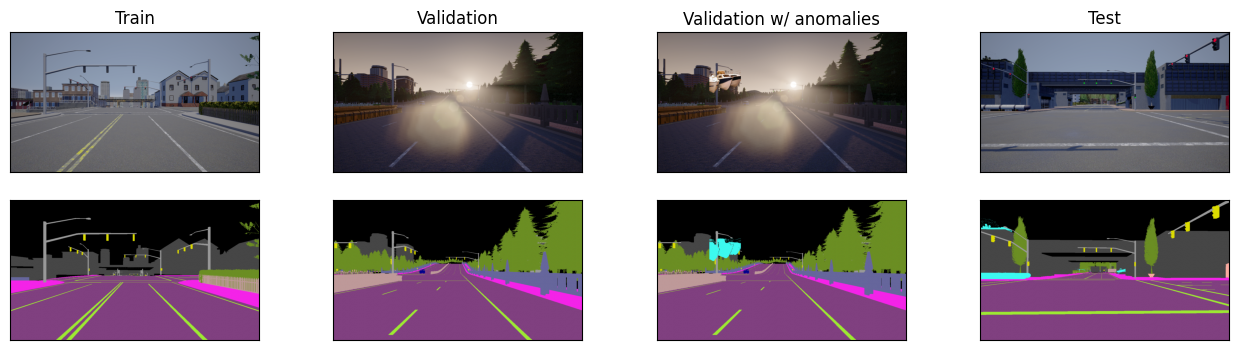

In [12]:
train_image, train_label = ds_train[0]
val_image, val_label = ds_val[0]
val_anom_image, val_anom_label = ds_val_anomalies[0]
test_image, test_label = __ds_test[0]

plt.figure(figsize=(16, 4))
plt.subplot(2, 4, 1)
plt.title("Train")
visualize_scene(train_image)
plt.subplot(2, 4, 2)
plt.title("Validation")
visualize_scene(val_image)
plt.subplot(2, 4, 3)
plt.title("Validation w/ anomalies")
visualize_scene(val_anom_image)
plt.subplot(2, 4, 4)
plt.title("Test")
visualize_scene(test_image)
plt.subplot(2, 4, 5)
visualize_annotation(train_label)
plt.subplot(2, 4, 6)
visualize_annotation(val_label)
plt.subplot(2, 4, 7)
visualize_annotation(val_anom_label)
plt.subplot(2, 4, 8)
visualize_annotation(test_label)
plt.show()

By diving deeper into the data, it can be observed that there are both instances of independent scenes and consecutive ones. As the task is on single images, it is safe to assume that temporal/spatial dependencies are not relevant. Therefore, no particular considerations are needed when forming a training batch regarding this aspect.

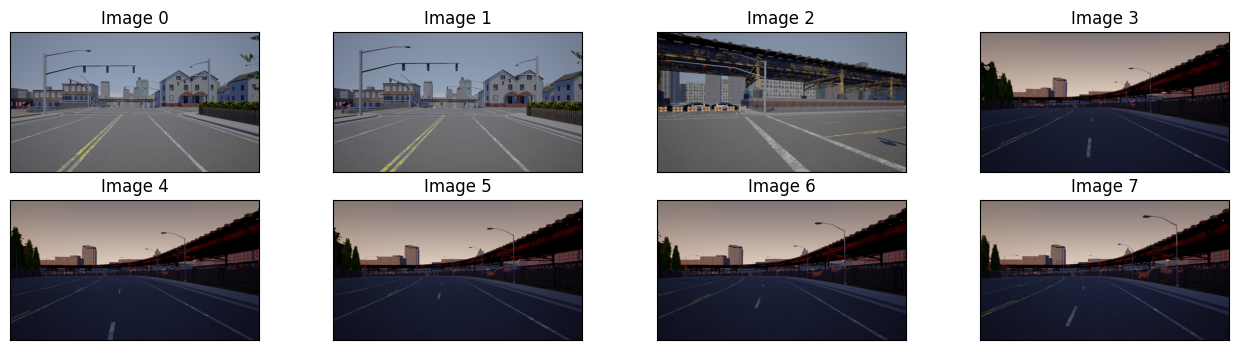

In [13]:
plt.figure(figsize=(16, 4))

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.title(f"Image {i}")
    visualize_scene(ds_train[i][0])

In terms of class distribution, it can be seen from the plots below that the classes are roughly unbalanced in the same way across all three splits. This indicates that there is no need for reweighing the loss function when training. To empirically confirm this, a weighted model will be also experimented with.

In [14]:
def get_class_counts(ds, num_classes=14):
    class_counts = [0] * num_classes

    for i in tqdm(range(len(ds))):
        classes, counts = ds[i][1].unique(return_counts=True)
        for j in range(len(classes)):
            class_counts[classes[j]] += counts[j].item()

    return np.array(class_counts)

def plot_class_distribution(class_counts, title="", scale="linear", num_classes=14):
    plt.barh(range(len(class_counts)), class_counts)
    plt.title(title)
    plt.xlabel(f"Count ({scale})")
    plt.ylabel("Class")
    plt.yticks(range(num_classes))
    plt.xscale(scale)


if RUN_DATA_EXPLORATION:
    class_count_train = get_class_counts(ds_train)
    class_count_val = get_class_counts(ds_val)
    class_count_test = get_class_counts(__ds_test)
else:
    class_count_train = np.array([1465351059, 567381185, 58982347, 22047241, 868060, 58867769, 63524255, 1573790159, 316983236, 416765104, 11689770, 162203306, 4746509, 0])
    class_count_val = np.array([269463074, 120766393, 21536012, 4309583, 20319, 5780099, 12482596, 344159100, 42262849, 98579343, 375774, 29420657, 1013801, 0])
    class_count_test = np.array([424877639, 166108644, 15544806, 8193403, 0, 10774864, 25619696, 515092874, 53327213, 119629690, 2149430, 24534419, 2303533, 14243789])
    
class_freq_train = class_count_train / class_count_train.sum()
class_freq_val = class_count_val / class_count_val.sum()
class_freq_test = class_count_test / class_count_test.sum()

Split UNLABELED (0) BUILDING (1) FENCE (2) OTHER (3) PEDESTRIAN (4)  \
0  Train       31.025%      12.013%    1.249%    0.467%         0.018%   
1    Val       28.359%      12.710%    2.267%    0.454%         0.002%   
2   Test       30.735%      12.016%    1.124%    0.593%         0.000%   

  POLE (5) ROAD_LINE (6) ROAD (7) SIDEWALK (8) VEGETATION (9) CAR (10)  \
0   1.246%        1.345%  33.320%       6.711%         8.824%   0.247%   
1   0.608%        1.314%  36.221%       4.448%        10.375%   0.040%   
2   0.779%        1.853%  37.261%       3.858%         8.654%   0.155%   

  WALL (11) TRAFFIC_SIGN (12) ANOMALY (13)  
0    3.434%            0.100%       0.000%  
1    3.096%            0.107%       0.000%  
2    1.775%            0.167%       1.030%

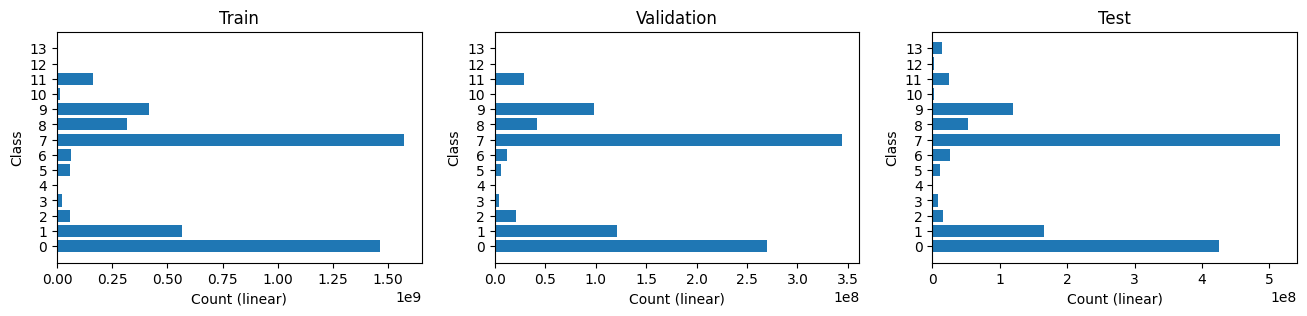

In [15]:
display(
    pd.DataFrame(
        data = [
            ["Train"] + [f"{freq*100:.3f}%" for freq in class_freq_train],
            ["Val"] + [f"{freq*100:.3f}%" for freq in class_freq_val],
            ["Test"] + [f"{freq*100:.3f}%" for freq in class_freq_test],
        ],
        columns = ["Split"] + [f"{c.name} ({c.value})" for c in StreetHazardsClasses]
    )
)

plt.figure(figsize=(16, 3))
plt.subplot(1, 3, 1)
plot_class_distribution(class_count_train, title="Train", scale="linear")
plt.subplot(1, 3, 2)
plot_class_distribution(class_count_val ,title="Validation", scale="linear")
plt.subplot(1, 3, 3)
plot_class_distribution(class_count_test, title="Test", scale="linear")
plt.show()

A small consideration must be made for the class UNLABELED and OTHER. From a visual analysis, it can be seen that UNLABELED is used to represent the background, which is mostly the sky. However, there are instances where other elements (which seems like bridges, elevated railways, …) are included in the background. OTHER also seems to represent multiple different objects. Hence, it must be noted that this could be a source of ambiguity and misclassifications that can affect the final results.

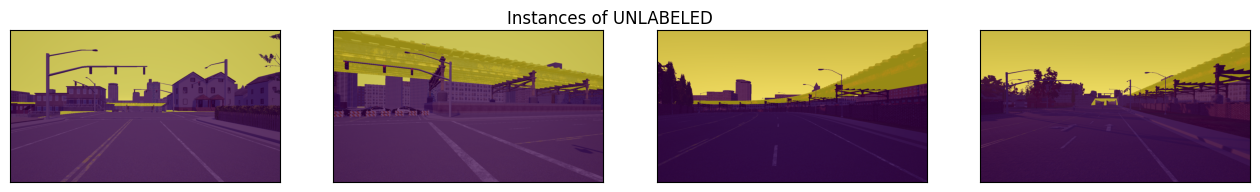

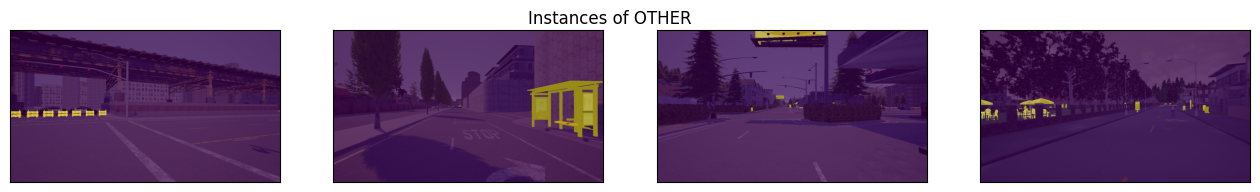

In [16]:
plt.figure(figsize=(16, 2))
plt.suptitle("Instances of UNLABELED")
for i, idx in enumerate([0, 2, 3, 150]):
    plt.subplot(1, 4, i+1)
    visualize_scene(ds_train[idx][0])
    plt.imshow(ds_train[idx][1] == StreetHazardsClasses.UNLABELED, alpha=0.6)
plt.show()

plt.figure(figsize=(16, 2))
plt.suptitle("Instances of OTHER")
for i, idx in enumerate([2, 2100, 2700, 3800]):
    plt.subplot(1, 4, i+1)
    visualize_scene(ds_train[idx][0])
    plt.imshow(ds_train[idx][1] == StreetHazardsClasses.OTHER, alpha=0.6)
plt.show()

---
## <a id='toc1_6_'></a>[3. Method](#toc0_)

### <a id='toc1_6_1_'></a>[3.1. Workflow](#toc0_)

The overall method does the following during inference:
1. Down-sample the input image to a resolution of $512 \times 512$ (the one required by MobileViT) and pass it through the DeepLabV3-MobileViT-small model.
2. The closed-set semantic segmentation task is solved using the up-scaled output logits.
3. Consider the embeddings outputted by MobileViT ($160 \times 32 \times 32$ if reshaped to be image-like). For each of them, compute the average distance to the nearest (pre-computed) training embedding(s) to obtain a $32 \times 32$ distance matrix.
4. Up-sample the distance matrix to match the image resolution and obtain the anomaly scores.
5. Use SLIC to segment the input image into superpixels. 
6. For each superpixel, its anomaly score is the average anomaly score of every pixel within it. The new anomaly map is used to solve the anomaly segmentation task.

For superpixel segmentation, although there are many algorithms, SLIC has been chosen as it has a fast implementation in Python.

In [17]:
segmenter_main = load_segmenter("apple/deeplabv3-mobilevit-small", DEEPLABV3_MOBILE_VIT_S_MAIN_DIR)

### <a id='toc1_6_2_'></a>[3.2. Training details](#toc0_)

#### <a id='toc1_6_2_1_'></a>[3.2.1. Segmentation model](#toc0_)

The training configuration for the best model is the following:
- AdamW as optimizer, following the current best practices.
- $2 \cdot 10^{-4}$ as learning rate. Smaller and bigger values were tried and the chosen one has been found to have the best balance between convergence speed and performance.
- $0.1$ for weight decay. Although, generally speaking it does not have perceivable effects in the final result. Further analysis is done in the following section on tuning.
- Cross entropy as loss.
- 30 epochs of training with early stopping monitoring mIoU.
- Batch size of 8 to fit the available memory.

Moreover, as MobileViT-small works with $512 \times 512$ images and to speed-up training, both training images and annotations are down-sampled to that shape. As other methods in the literature work by cropping, this choice is also assessed in the next section on tuning.

A notable observation that can be made on the training plots is that the validation loss and mIoU tend to not be correlated. In fact, during training, the loss tend to slightly worsen while mIoU improves. This has motivated the use of weight decay (albeit without effects) and by monitoring mIoU instead of the loss with early stopping. An interpretation of this behavior is that the resulting model outputs distributions that select the correct class but without a clear majority (i.e., can be seen as uncertainty).

Max validation mIoU: 51.05


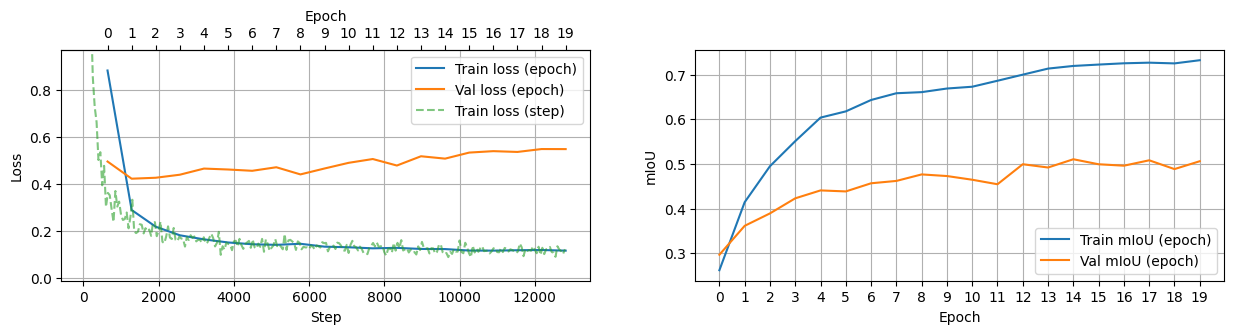

In [18]:
df_logs = pd.read_csv(os.path.join(DEEPLABV3_MOBILE_VIT_S_MAIN_DIR, "logs.csv"))

print(f"Max validation mIoU: {df_logs['val_miou'].max()*100:.2f}")
plot_logs(df_logs)
plt.show()

#### <a id='toc1_6_2_2_'></a>[3.2.2. Anomaly detector](#toc0_)

To "train" the $k$-NN model for anomaly detection, a subset of the training set ($500$) to speed-up computation is considered and all the MobileViT embeddings of those images are computed ($500 \cdot 32 \cdot 32 = 512000$ vectors of $160$ dimensions). All these embeddings are used to fit a $k$-means model and its centroids are used as the actual samples of $k$-NN (i.e., the number of samples $k$-NN has available is the same as the number of $k$-means clusters).

### <a id='toc1_6_3_'></a>[3.3. Hyperparameter tuning](#toc0_)

#### <a id='toc1_6_3_1_'></a>[3.3.1. Segmentation model training](#toc0_)

To investigate the effectiveness of the training hyperparameters, the following experiments are performed:
- Use no weight decay.
- Use a lower weight decay.
- Use a higher weight decay.
- Use a weighted loss.
- Use random crops.

Both the standard and anomalous validation sets are used to test mIoU and AUPR. At this stage, MaxLogit is used as anomaly detection algorithm as it is hyperparameter-free and works out of the box without the need to fit it.

In [19]:
# Baseline

if RUN_TUNING:
    all_results["val"]["main"] = evaluate_segmenter(segmenter_main, ds_val, "Segmenter (baseline)")
    all_results["val_anom"]["main"] = evaluate_predictor(StandardPredictor(MaxLogitModel(segmenter_main)), ds_val_anomalies, "Segmenter (baseline)")
else:
    all_results["val"]["main"] = [{'model': 'Segmenter (baseline)', 'miou': 0.5104538146487005, 'iou_c': [0.8502693730805905, 0.7782005016115813, 0.31883027046917184, 0.3740129647716634, 0.3207813050456022, 0.13640429102910176, 0.3671863850896293, 0.9235283904530082, 0.6454786676602626, 0.7883368617912305, 0.46022134904105144, 0.4895308278110441, 0.18311840257916906]}]
    all_results["val_anom"]["main"] = [{'model': 'Segmenter (baseline)', 'miou': 0.47047376637902844, 'iou_c': [0.8482244065442088, 0.7721646018511203, 0.3004418983532618, 0.34274448218232956, 0.06562703760052163, 0.1336815870432678, 0.3615898434476134, 0.9206359110847429, 0.636738245912039, 0.7854702975250939, 0.280590462129206, 0.48915323499937113, 0.17909695425459343], 'ap': 0.16960206396359223}]

display_results(all_results["val"]["main"], caption="Results on validation set")
display_results(all_results["val_anom"]["main"], caption="Results on validation set with anomalies")

##### <a id='toc1_6_3_1_1_'></a>[3.3.1.1. No weight decay](#toc0_)

By not using weight decay, it can be seen that mIoU slightly improves while AUPR decreases. 

In this case, and also in the following ones, it is not clear which one to favor due to the subtle differences. Just to fix a criterion to systematically pick the preferred configuration, it has been decided to prioritize the model with the highest AUPR in case of ambiguity. Therefore, in this case using weight decay is better.

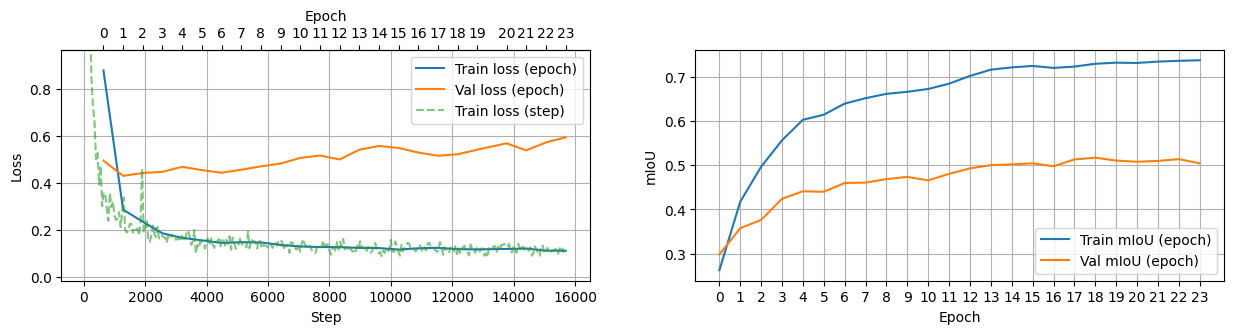

In [20]:
segmenter_no_decay = load_segmenter("apple/deeplabv3-mobilevit-small", DEEPLABV3_MOBILE_VIT_S_ABL_NO_DECAY_DIR)

if RUN_TUNING:
    all_results["val"]["no_decay"] = evaluate_segmenter(segmenter_no_decay, ds_val, "Segmenter (no weight decay)")
    all_results["val_anom"]["no_decay"] = evaluate_predictor(StandardPredictor(MaxLogitModel(segmenter_no_decay)), ds_val_anomalies, "Segmenter (no weight decay)")
else:
    all_results["val"]["no_decay"] = [{'model': 'Segmenter (no weight decay)', 'miou': 0.5174396140725182, 'iou_c': [0.8497774418074684, 0.7778359947252146, 0.3840316249082635, 0.31238002473226834, 0.2884117742196345, 0.16456118318146756, 0.4331501505968944, 0.9275113039516588, 0.6570178146426676, 0.7887926121506451, 0.4778284220968496, 0.4842914348739957, 0.1811252010557091]}]
    all_results["val_anom"]["no_decay"] = [{'model': 'Segmenter (no weight decay)', 'miou': 0.47638571463540236, 'iou_c': [0.8471145521220838, 0.771186696937396, 0.36442096079751657, 0.28708315430719544, 0.07778131973222824, 0.1606253015808509, 0.4266339709269689, 0.9247744193043121, 0.6518475018717728, 0.7854429955076925, 0.25450553257630554, 0.4691412724684001, 0.17245661212750787], 'ap': 0.1538555661275632}]

display_results(all_results["val"]["no_decay"] + all_results["val"]["main"], caption="Results on validation set")
display_results(all_results["val_anom"]["no_decay"] + all_results["val_anom"]["main"], caption="Results on validation set with anomalies")

plot_logs( pd.read_csv(os.path.join(DEEPLABV3_MOBILE_VIT_S_ABL_NO_DECAY_DIR, "logs.csv")) )

##### <a id='toc1_6_3_1_2_'></a>[3.3.1.2. Lower weight decay](#toc0_)

By using a smaller weight decay, it can be observed that mIoU is marginally affected in both validation sets while AUPR worsens a bit. Therefore, the current choice of $0.1$ is better.

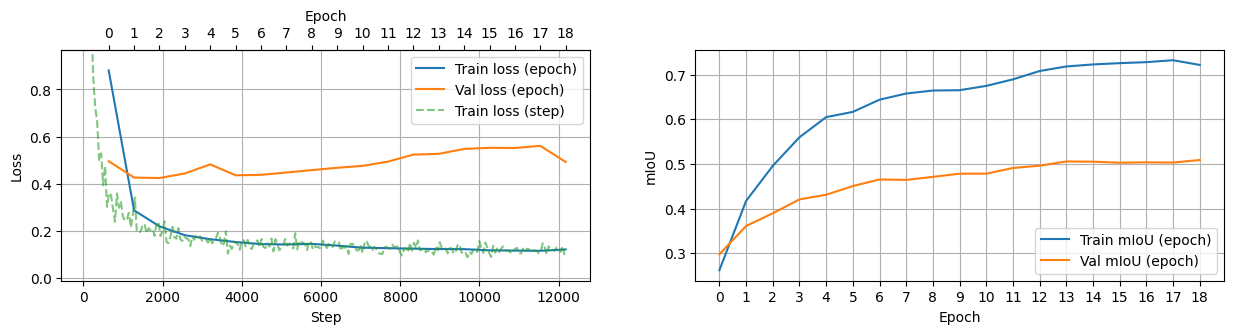

In [21]:
segmenter_low_decay = load_segmenter("apple/deeplabv3-mobilevit-small", DEEPLABV3_MOBILE_VIT_S_ABL_LOWER_DECAY_DIR)

if RUN_TUNING:
    all_results["val"]["low_decay"] = evaluate_segmenter(segmenter_low_decay, ds_val, "Segmenter (lower weight decay)")
    all_results["val_anom"]["low_decay"] = evaluate_predictor(StandardPredictor(MaxLogitModel(segmenter_low_decay)), ds_val_anomalies, "Segmenter (lower weight decay)")
else:
    all_results["val"]["low_decay"] = [{'model': 'Segmenter (lower weight decay)', 'miou': 0.5090487687646001, 'iou_c': [0.8474986483293182, 0.7653217925018895, 0.39659724503481814, 0.34461179171930334, 0.2992749395782982, 0.1511820013124342, 0.3994969634456577, 0.9255116627898051, 0.682538427951868, 0.7823007071436962, 0.5027802673749114, 0.3740531265738711, 0.14646642018393105]}]
    all_results["val_anom"]["low_decay"] = [{'model': 'Segmenter (lower weight decay)', 'miou': 0.4738096623694024, 'iou_c': [0.8458191924914958, 0.7625076649567206, 0.39079713177499414, 0.32107622125979773, 0.060740200859601925, 0.14786958578094322, 0.3935108263087551, 0.9224960312174911, 0.6763497474336337, 0.7783423107618166, 0.3391700317346458, 0.3781360953357251, 0.14271057088661135], 'ap': 0.15561662696732165}]

display_results(all_results["val"]["low_decay"] + all_results["val"]["main"], caption="Results on validation set")
display_results(all_results["val_anom"]["low_decay"] + all_results["val_anom"]["main"], caption="Results on validation set with anomalies")

plot_logs( pd.read_csv(os.path.join(DEEPLABV3_MOBILE_VIT_S_ABL_LOWER_DECAY_DIR, "logs.csv")) )

##### <a id='toc1_6_3_1_3_'></a>[3.3.1.3. Higher weight decay](#toc0_)

For the sake of experimentation, a more uncommon weight decay of $0.2$ has been experimented with to test a higher value. Results show that mIoU remains roughtly the same on the validation set, while on the anomalous set mIoU increases and AUPR decreases. Therefore, by favoring AUPR, the initial choice of $0.1$ is better.

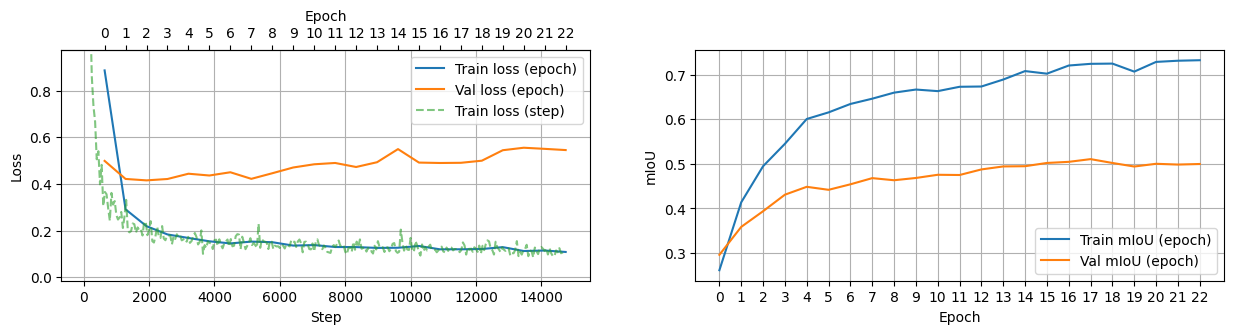

In [22]:
segmenter_high_decay = load_segmenter("apple/deeplabv3-mobilevit-small", DEEPLABV3_MOBILE_VIT_S_ABL_HIGHER_DECAY_DIR)

if RUN_TUNING:
    all_results["val"]["high_decay"] = evaluate_segmenter(segmenter_high_decay, ds_val, "Segmenter (higher weight decay)")
    all_results["val_anom"]["high_decay"] = evaluate_predictor(StandardPredictor(MaxLogitModel(segmenter_high_decay)), ds_val_anomalies, "Segmenter (higher weight decay)")
else:
    all_results["val"]["high_decay"] = [{'model': 'Segmenter (higher weight decay)', 'miou': 0.5107771966082855, 'iou_c': [0.8448403818686091, 0.7835052350185812, 0.4624956491997456, 0.37315131794506773, 0.2178056391083125, 0.14687693382339154, 0.3619689744925716, 0.9223838037911551, 0.6927737942577383, 0.7850693660684025, 0.42884719859640374, 0.46622066656727873, 0.15416459517045455]}]
    all_results["val_anom"]["high_decay"] = [{'model': 'Segmenter (higher weight decay)', 'miou': 0.4805215541060921, 'iou_c': [0.842945196182892, 0.7779880325671786, 0.4301457687530849, 0.3473633606079315, 0.04299957850675116, 0.14500763062234934, 0.3589236627297452, 0.9195089153937944, 0.683225051139709, 0.7824874423790705, 0.30271938441140545, 0.4604142544313964, 0.15305192565388956], 'ap': 0.15355450180157643}]

display_results(all_results["val"]["high_decay"] + all_results["val"]["main"], caption="Results on validation set")
display_results(all_results["val_anom"]["high_decay"] + all_results["val_anom"]["main"], caption="Results on validation set with anomalies")

plot_logs( pd.read_csv(os.path.join(DEEPLABV3_MOBILE_VIT_S_ABL_HIGHER_DECAY_DIR, "logs.csv")) )

##### <a id='toc1_6_3_1_4_'></a>[3.3.1.4. Weighted loss](#toc0_)

By weighing the loss to account for class imbalance, it can be seen that mIoU is significantly impacted. This is expected due to the fact that the classes in the three splits are roughly distributed in the same way. Therefore, weights are not applied to the loss.

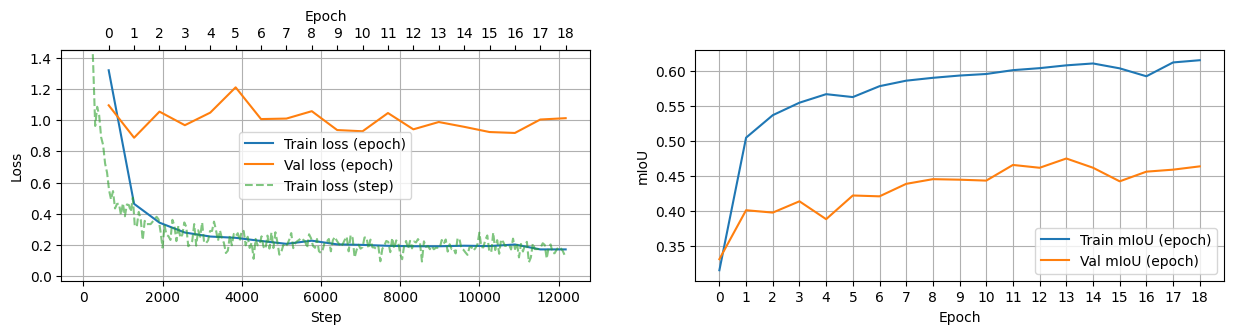

In [23]:
segmenter_loss_weights = load_segmenter("apple/deeplabv3-mobilevit-small", DEEPLABV3_MOBILE_VIT_S_ABL_WEIGHTED_DIR)

if RUN_TUNING:
    all_results["val"]["loss_weights"] = evaluate_segmenter(segmenter_loss_weights, ds_val, "Segmenter (weighted loss)")
    all_results["val_anom"]["loss_weights"] = evaluate_predictor(StandardPredictor(MaxLogitModel(segmenter_loss_weights)), ds_val_anomalies, "Segmenter (weighted loss)")
else:
    all_results["val"]["loss_weights"] = [{'model': 'Segmenter (weighted loss)', 'miou': 0.4752015426882876, 'iou_c': [0.8438854463874153, 0.7754298454829276, 0.40464276135584115, 0.28406560692154864, 0.1222634251535396, 0.1801009514387023, 0.29001111460688694, 0.8626281517028335, 0.6278169996472848, 0.7528373406124022, 0.4746743983835183, 0.430172863090408, 0.12909115016443107]}]
    all_results["val_anom"]["loss_weights"] = [{'model': 'Segmenter (weighted loss)', 'miou': 0.4403186460989716, 'iou_c': [0.8391780078934553, 0.7713401595160907, 0.3984985521121795, 0.2723048125179901, 0.038205753875314545, 0.1673199810874823, 0.28927744757201423, 0.8581242445131904, 0.6245213869185957, 0.7499535509576828, 0.18285306355700887, 0.4213316727517728, 0.11123376601385386], 'ap': 0.16656035781599487}]

display_results(all_results["val"]["loss_weights"] + all_results["val"]["main"], caption="Results on validation set")
display_results(all_results["val_anom"]["loss_weights"] + all_results["val_anom"]["main"], caption="Results on validation set with anomalies")
display_classwise_iou(all_results["val"]["main"], "Class-wise IoU on validation set (baseline)")
display_classwise_iou(all_results["val"]["loss_weights"], "Class-wise IoU on validation set (weighted loss)")

plot_logs( pd.read_csv(os.path.join(DEEPLABV3_MOBILE_VIT_S_ABL_WEIGHTED_DIR, "logs.csv")) )

##### <a id='toc1_6_3_1_5_'></a>[3.3.1.5. Random crops](#toc0_)

By using random crops of the input instead of a full resize, results show that mIoU slightly increases and AUPR slightly decreases. Therefore, as before, AUPR is favored and the input is down-sampled instead of cropping it.

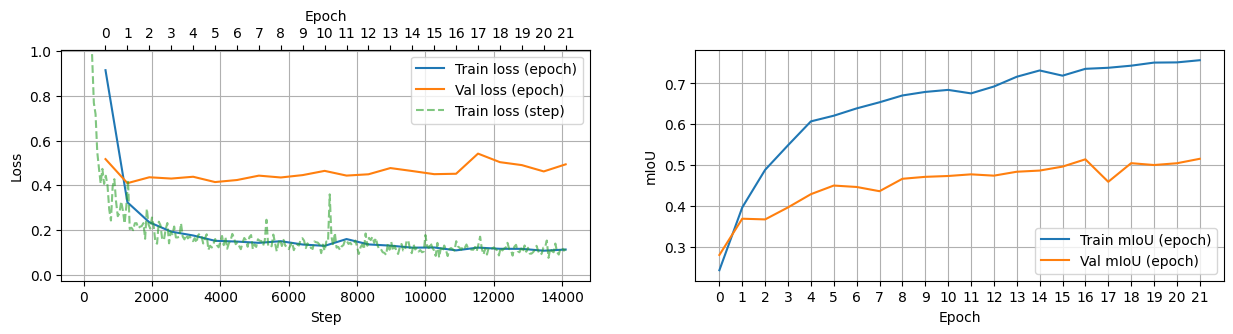

In [24]:
segmenter_crop = load_segmenter("apple/deeplabv3-mobilevit-small", DEEPLABV3_MOBILE_VIT_S_ABL_CROP_DIR)

if RUN_TUNING:
    all_results["val"]["crop"] = evaluate_segmenter(segmenter_crop, ds_val, "Segmenter (random crops)")
    all_results["val_anom"]["crop"] = evaluate_predictor(StandardPredictor(MaxLogitModel(segmenter_crop)), ds_val_anomalies, "Segmenter (random crops)")
else:
    all_results["val"]["crop"] = [{'model': 'Segmenter (random crops)', 'miou': 0.5156155439919905, 'iou_c': [0.8492509948705084, 0.7889854308746476, 0.4556949774486196, 0.3748010590674168, 0.25324234655406425, 0.1495259853140941, 0.39142800164960945, 0.9217541060680803, 0.67141017247223, 0.7896008573403245, 0.41112305087628426, 0.4625746393373875, 0.18361045002261012]}]
    all_results["val_anom"]["crop"] = [{'model': 'Segmenter (random crops)', 'miou': 0.4805107059658126, 'iou_c': [0.8478246895770408, 0.7884067762342457, 0.43905048478530323, 0.3347911238672955, 0.04899411891271606, 0.14753073942843425, 0.38291156158766637, 0.91985478957078, 0.6653184419661377, 0.7868528171194763, 0.25845366357069144, 0.459524531302701, 0.16712543963307513], 'ap': 0.16009470152533845}]

display_results(all_results["val"]["crop"] + all_results["val"]["main"], caption="Results on validation set")
display_results(all_results["val_anom"]["crop"] + all_results["val_anom"]["main"], caption="Results on validation set with anomalies")

plot_logs( pd.read_csv(os.path.join(DEEPLABV3_MOBILE_VIT_S_ABL_CROP_DIR, "logs.csv")) )

##### <a id='toc1_6_3_1_6_'></a>[3.3.1.6. Wrap-up and qualitative results](#toc0_)

From the experiments in this section, it is possible to conclude that:
- In this configuration, weight decay is not particularly relevant for the final result.
- As train and test set have a similar distribution, weighing the loss has a negative impact on performance.
- Training with random crops seems to improve mIoU while decreasing in AUPR, but, as for weight decay, there are no drastic differences.

Visually, results with varying weight decay and random crops are mostly similar. With the weighted loss, as one could expect, minority classes (e.g., road lines) are more frequently classified.

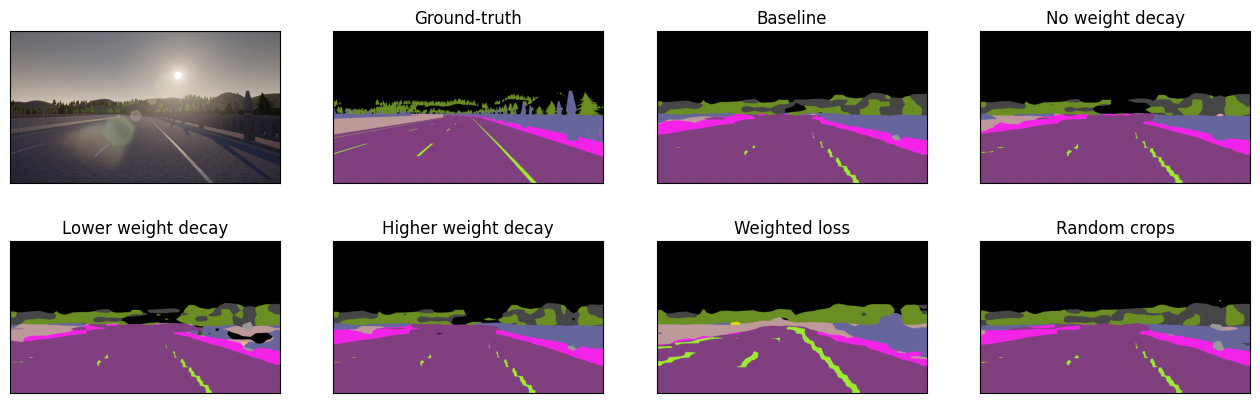

In [25]:
image, labels = ds_val[42]

with torch.no_grad():
    segm_logits_main = segmenter_main(image.unsqueeze(0).to(DEVICE))
    segm_logits_no_decay = segmenter_no_decay(image.unsqueeze(0).to(DEVICE))
    segm_logits_low_decay = segmenter_low_decay(image.unsqueeze(0).to(DEVICE))
    segm_logits_high_decay = segmenter_high_decay(image.unsqueeze(0).to(DEVICE))
    segm_logits_loss_weights = segmenter_loss_weights(image.unsqueeze(0).to(DEVICE))
    segm_logits_crop = segmenter_crop(image.unsqueeze(0).to(DEVICE))

plt.figure(figsize=(16, 5))
plt.subplot(2, 4, 1)
visualize_scene(image)
plt.subplot(2, 4, 2)
plt.title("Ground-truth")
visualize_annotation(labels)
plt.subplot(2, 4, 3)
plt.title("Baseline")
visualize_annotation(torch.argmax(segm_logits_main.cpu().squeeze(0), dim=0))
plt.subplot(2, 4, 4)
plt.title("No weight decay")
visualize_annotation(torch.argmax(segm_logits_no_decay.cpu().squeeze(0), dim=0))
plt.subplot(2, 4, 5)
plt.title("Lower weight decay")
visualize_annotation(torch.argmax(segm_logits_low_decay.cpu().squeeze(0), dim=0))
plt.subplot(2, 4, 6)
plt.title("Higher weight decay")
visualize_annotation(torch.argmax(segm_logits_high_decay.cpu().squeeze(0), dim=0))
plt.subplot(2, 4, 7)
plt.title("Weighted loss")
visualize_annotation(torch.argmax(segm_logits_loss_weights.cpu().squeeze(0), dim=0))
plt.subplot(2, 4, 8)
plt.title("Random crops")
visualize_annotation(torch.argmax(segm_logits_crop.cpu().squeeze(0), dim=0))
plt.show()

#### <a id='toc1_6_3_2_'></a>[3.3.2. Anomaly detector](#toc0_)

In this section, the following hyperparameters for the anomaly detection module are tuned:
- The number of neighbors to consider in $k$-NN.
- The number of clusters $k$-means has to determine (i.e., the amount of data points $k$-NN need to have available).
- The hyperparameters of SLIC for superpixel segmentation.

To tune them, the validation set with artificially added anomalies is used. As many experiments have to be executed, a random subset of it is used.

In [26]:
ds_val_anomalies_small = dataset_subset(ds_val_anomalies, 500, SEED)

##### <a id='toc1_6_3_2_1_'></a>[3.3.2.1. Number of neighbors](#toc0_)

In terms of number of neighboring embeddings to compare the query against, it can be seen that the performance in terms of AUPR roughly decreases linearly with the number of neighbors. Therefore, a single neighbor is the best choice to determine anomalies.

In [27]:
if RUN_TUNING:
    to_test_num_neighbors = range(1, 11)
    num_neighbors_results = []
    hidden_states = extract_hidden_states(segmenter_main, DataLoader(dataset_subset(ds_train, 500, SEED), batch_size=10))
    hidden_states_for_fit = sample_hidden_states(hidden_states, 1000, SEED) # The ideal number of sample is determined in the next section

    for num_neighbors in to_test_num_neighbors:
        print(f"Running with num_neighbors={num_neighbors}")
        model = KNNModel(segmenter_main, n_neighbors=num_neighbors).fit(hidden_states_for_fit)
        predictor = StandardPredictor(model)

        L.seed_everything(SEED, verbose=False)
        results = evaluate_model(predictor, ds_val_anomalies_small, device=DEVICE, compute_miou=False)
        num_neighbors_results.append({ "num_neighbors": num_neighbors, "ap": results["ap"] })
else:
    num_neighbors_results = [{'num_neighbors': 1, 'ap': 0.1947749275854813}, {'num_neighbors': 2, 'ap': 0.19427496482412013}, {'num_neighbors': 3, 'ap': 0.1920241408182454}, {'num_neighbors': 4, 'ap': 0.1903389060749364}, {'num_neighbors': 5, 'ap': 0.18832123094585423}, {'num_neighbors': 6, 'ap': 0.18543473705050106}, {'num_neighbors': 7, 'ap': 0.1823873308670997}, {'num_neighbors': 8, 'ap': 0.17939995289702093}, {'num_neighbors': 9, 'ap': 0.17655490481809324}, {'num_neighbors': 10, 'ap': 0.17387920358866743}]

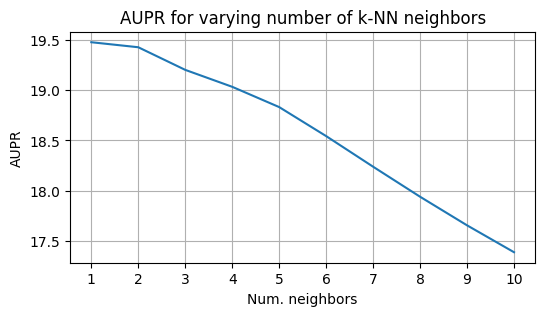

In [28]:
plt.figure(figsize=(6, 3))
plt.title("AUPR for varying number of k-NN neighbors")
plt.plot([r["num_neighbors"] for r in num_neighbors_results], [r["ap"]*100 for r in num_neighbors_results])
plt.xticks([r["num_neighbors"] for r in num_neighbors_results])
plt.xlabel("Num. neighbors")
plt.ylabel("AUPR")
plt.grid()
plt.show()

##### <a id='toc1_6_3_2_2_'></a>[3.3.2.2. Number of k-NN data points / Number of clusters](#toc0_)

In terms of amount of samples $k$-NN should have available, it can be seen that performance grows by increasing data points.

In this analysis, the pool of available embeddings is computed on a subset of the training sets, then:
- For plain $k$-NN, the data points are determined by randomly sampling the desired number from the pool.
- For $k$-NN with $k$-means, the data points are the centroids determined by $k$-means with the number of clusters equal to the desired number of data points.

As $k$-means requires more time to converge for increasing number of clusters, the experiments were not done on large numbers. Still, it can be seen that choosing the samples for $k$-NN with $k$-means allows achieving better results compared to randomly sampling them. In the rest of the notebook, for speed purposes, the number of cluster will be $2000$.

In [29]:
if RUN_TUNING:
    num_clusters_results = []
    knn_num_data_results = []
    hidden_states = extract_hidden_states(segmenter_main, DataLoader(dataset_subset(ds_train, 500, SEED), batch_size=10))

    for num_data in [10, 100, 200, 500, 1000, 2000, 3000]:
        print(f"Running k-means for {num_data} datapoints")
        L.seed_everything(SEED, verbose=False)
        model = KmeansModel(segmenter_main, num_clusters=num_data).fit(hidden_states)
        predictor = StandardPredictor(model)
        results = evaluate_model(predictor, ds_val_anomalies_small, device=DEVICE, compute_miou=False)
        num_clusters_results.append({ "num_data": num_data, "ap": results["ap"] })

        print(f"Running k-NN for {num_data} datapoints")
        L.seed_everything(SEED, verbose=False)
        model = KNNModel(segmenter_main).fit( sample_hidden_states(hidden_states, num_data, SEED) )
        predictor = StandardPredictor(model)
        results = evaluate_model(predictor, ds_val_anomalies_small, device=DEVICE, compute_miou=False)
        knn_num_data_results.append({ "num_data": num_data, "ap": results["ap"] })
else:
    num_clusters_results = [{'num_data': 10, 'ap': 0.1538137367637375}, {'num_data': 100, 'ap': 0.198616565412227}, {'num_data': 200, 'ap': 0.22836983660226468}, {'num_data': 500, 'ap': 0.2491150936026216}, {'num_data': 1000, 'ap': 0.2566104139132997}, {'num_data': 2000, 'ap': 0.2669750973605973}, {'num_data': 3000, 'ap': 0.2731835068297395}]
    knn_num_data_results = [{'num_data': 10, 'ap': 0.06898287623348882}, {'num_data': 100, 'ap': 0.13497221214065835}, {'num_data': 200, 'ap': 0.1562451390782702}, {'num_data': 500, 'ap': 0.1798926314242656}, {'num_data': 1000, 'ap': 0.1947749275854813}, {'num_data': 2000, 'ap': 0.22507075749081937}, {'num_data': 3000, 'ap': 0.2383407392217743}]

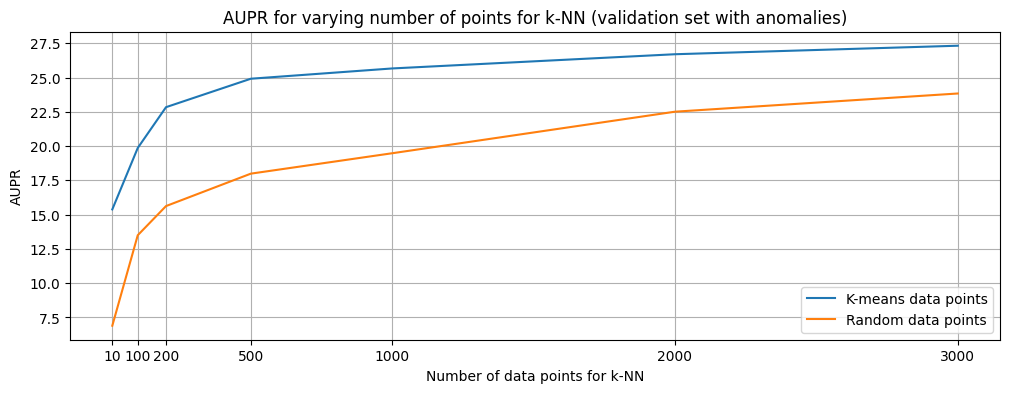

In [30]:
plt.figure(figsize=(12, 4))
plt.title("AUPR for varying number of points for k-NN (validation set with anomalies)")
plt.plot([r["num_data"] for r in num_clusters_results], [r["ap"]*100 for r in num_clusters_results], label="K-means data points")
plt.plot([r["num_data"] for r in knn_num_data_results], [r["ap"]*100 for r in knn_num_data_results], label="Random data points")
plt.xticks([r["num_data"] for r in knn_num_data_results])
plt.xlabel("Number of data points for k-NN")
plt.ylabel("AUPR")
plt.legend()
plt.grid()
plt.show()

##### <a id='toc1_6_3_2_3_'></a>[3.3.2.3. Superpixel hyperparameters](#toc0_)

To check whether superpixel segmentation improves anomaly predictions, grid-search is performed on the hyperparameters of SLIC. As tuning is done on two parameters, the results can be visualized in a heatmap. It can be seen that, compared to the baseline without superpixel segmentation, introducing SLIC greatly improves the results in terms of AUPR.

In [31]:
to_test_num_components = [100, 200, 500]
to_test_compactness = [0.1, 1, 10, 20, 50, 75, 100]

if RUN_TUNING:
    slic_params_results_matrix = np.zeros((len(to_test_num_components), len(to_test_compactness)))
    hidden_states = extract_hidden_states(segmenter_main, DataLoader(dataset_subset(ds_train, 500, SEED), batch_size=10))
    model = KmeansModel(segmenter_main).fit(hidden_states)

    baseline = evaluate_model(StandardPredictor(model), ds_val_anomalies_small, device=DEVICE, compute_miou=False)

    for i, num_components in enumerate(to_test_num_components):
        for j, compactness in enumerate(to_test_compactness):
            print(f"Running with num_components={num_components}, compactness={compactness}")
            predictor = SuperpixelPredictor(model, apply_on_segmentation=False, apply_on_anomaly=True, slic_num_components=num_components, slic_compactness=compactness)

            L.seed_everything(SEED, verbose=False)
            results = evaluate_model(predictor, ds_val_anomalies_small, device=DEVICE, compute_miou=False)
            slic_params_results_matrix[i, j] = results["ap"]
else:
    baseline = {'ap': 0.24684597070087647}
    slic_params_results_matrix = np.array([[0.24318989993435458, 0.24973245019701226, 0.28867382852519263, 0.30414008769919, 0.31033516695997926, 0.29463003550033584, 0.2811797009902454], [0.27771807517112, 0.28514103156452475, 0.32499905359979236, 0.3338013193868192, 0.32841435445089756, 0.3155366617597291, 0.30313539504503284], [0.29439742797690355, 0.3038211558380716, 0.3252118199542317, 0.32313133413051703, 0.3141073519389178, 0.30907129360895935, 0.3005564408505728]])

Baseline AUPR (without SLIC): 24.68


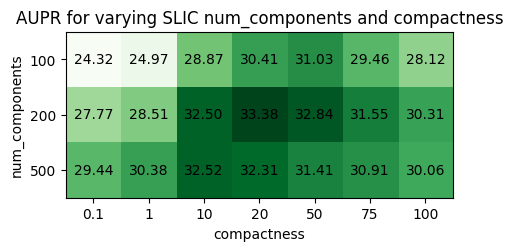

In [32]:
print(f"Baseline AUPR (without SLIC): {baseline['ap']*100:.2f}")

plt.figure(figsize=(5, 6))
plt.imshow(slic_params_results_matrix, cmap="Greens")
plt.title("AUPR for varying SLIC num_components and compactness")
for i in range(len(to_test_num_components)):
    for j in range(len(to_test_compactness)):
        text = plt.text(j, i, f"{slic_params_results_matrix[i, j]*100:.2f}", ha="center", va="center")
plt.xticks(range(len(to_test_compactness)), labels=to_test_compactness)
plt.yticks(range(len(to_test_num_components)), labels=to_test_num_components)
plt.xlabel("compactness")
plt.ylabel("num_components")
plt.show()

In qualitative terms, this configuration produces anomaly maps split in sections. Although fragmented, from a visual evaluation it can be seen that each section is more or less part of the same entity, therefore achieving the desired goal.

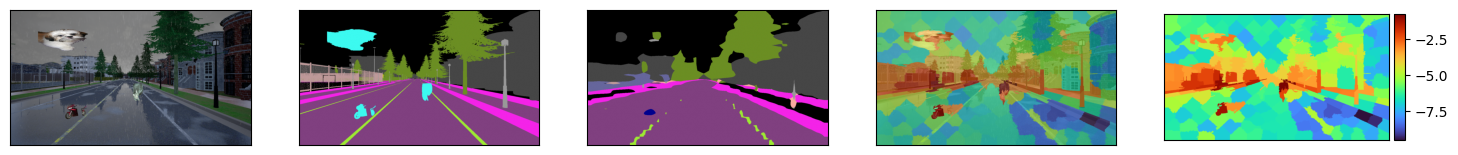

In [33]:
model = MaxLogitModel(segmenter_main)
predictor = SuperpixelPredictor(model, apply_on_segmentation=False, apply_on_anomaly=True, slic_num_components=200, slic_compactness=20)

L.seed_everything(SEED, verbose=False)
image, labels = ds_val_anomalies_small[42]
segm_preds, ood_scores = predictor(image.to(DEVICE).unsqueeze(0))
segm_preds, ood_scores = segm_preds.cpu(), ood_scores.cpu()

show_results(image, labels, segm_preds[0], ood_scores[0])

Finally, applying SLIC to the segmentation maps has also been attempted. In this case, instead of averaging, the most frequent class in a patch is considered.

Results show that the overall mIoU worsens with SLIC. From a visual analysis, it can be seen that applying SLIC helps to refine the predictions of some objects (e.g., trees), but it disrupts others by mixing them with neighboring predictions.

In [34]:
model = MaxLogitModel(segmenter_main)
standard_predictor = StandardPredictor(model)
superpixel_predictor = SuperpixelPredictor(model, apply_on_segmentation=True, apply_on_anomaly=True)

if RUN_TUNING:
    segm_superpixel_results = evaluate_predictors([
        PredictorContainer(standard_predictor, "Non-SLIC segmenter"),
        PredictorContainer(superpixel_predictor, "SLIC segmenter")
    ], ds_val, compute_ap=False)
else:
    segm_superpixel_results = [ {"model": "Non-SLIC segmenter", "miou": 0.5104538146487005}, {"model": "SLIC segmenter", "miou": 0.44923482556334665} ]

display_results(segm_superpixel_results)

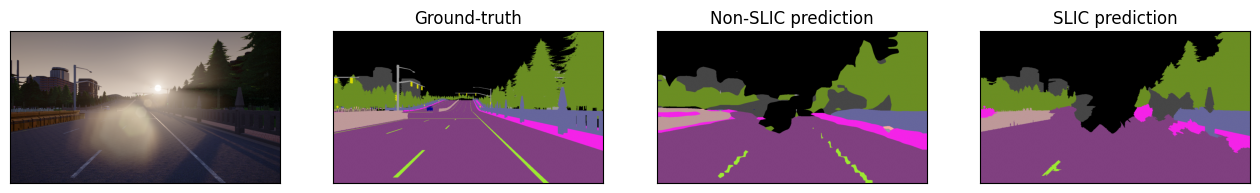

In [35]:
image, labels = ds_val[0]
standard_segm_map, _ = standard_predictor(image.unsqueeze(0).to(DEVICE))
superpixel_segm_map, _ = superpixel_predictor(image.unsqueeze(0).to(DEVICE))

plt.figure(figsize=(16, 5))
plt.subplot(1, 4, 1)
visualize_scene(image)
plt.subplot(1, 4, 2)
plt.title("Ground-truth")
visualize_annotation(labels)
plt.subplot(1, 4, 3)
plt.title("Non-SLIC prediction")
visualize_annotation(standard_segm_map.cpu().squeeze(0))
plt.subplot(1, 4, 4)
plt.title("SLIC prediction")
visualize_annotation(superpixel_segm_map.cpu().squeeze(0))
plt.show()

---
## <a id='toc1_7_'></a>[4. Results](#toc0_)

In [36]:
predictors_main = load_predictors(
    segmenter_card = "apple/deeplabv3-mobilevit-small", 
    segmenter_ckp_path = DEEPLABV3_MOBILE_VIT_S_MAIN_DIR, 
    PredictorClass = SuperpixelPredictor, 
    ds_train = ds_train,
    use_prefitted = LOAD_PREFITTED
)

### <a id='toc1_7_1_'></a>[4.1. Quantitative results](#toc0_)

Results on the test set show that the proposed method that combines $k$-means and $k$-NN is the best performing one. In terms of baseline, maximum softmax probability and MaxLogit have roughly the same performance. On the other hand, standardized MaxLogit is the worst performing, most likely due to the fact that it is highly dependent on the performance of the segmentation model and, due to the unbalanced nature of the data, mean and variance for minority classes are less representative.

By analyzing the IoU class-wise, as expected, it can be seen that the most frequent classes are those classified the best.

In [37]:
if RUN_EVALUATION:
    all_results["test"]["main"] = evaluate_predictors(predictors_main, __ds_test)
else:
    all_results["test"]["main"] = [{'model': 'Maximum softmax', 'miou': 0.48300180341862575, 'iou_c': [0.8473047762474288, 0.708869201459628, 0.2951575984899288, 0.2985249222297859, 0.0, 0.1390436782132098, 0.32976948748853674, 0.9441846006474023, 0.6779678351866865, 0.7598500967899343, 0.5861689755325172, 0.5113235279045996, 0.18085874425247708], 'ap': 0.11962491213490274}, {'model': 'MaxLogit', 'miou': 0.48300180341862575, 'iou_c': [0.8473047762474288, 0.708869201459628, 0.2951575984899288, 0.2985249222297859, 0.0, 0.1390436782132098, 0.32976948748853674, 0.9441846006474023, 0.6779678351866865, 0.7598500967899343, 0.5861689755325172, 0.5113235279045996, 0.18085874425247708], 'ap': 0.11680217327898083}, {'model': 'Standardized MaxLogit', 'miou': 0.48300180341862575, 'iou_c': [0.8473047762474288, 0.708869201459628, 0.2951575984899288, 0.2985249222297859, 0.0, 0.1390436782132098, 0.32976948748853674, 0.9441846006474023, 0.6779678351866865, 0.7598500967899343, 0.5861689755325172, 0.5113235279045996, 0.18085874425247708], 'ap': 0.08750892588810064}, {'model': 'k-NN', 'miou': 0.48300180341862575, 'iou_c': [0.8473047762474288, 0.708869201459628, 0.2951575984899288, 0.2985249222297859, 0.0, 0.1390436782132098, 0.32976948748853674, 0.9441846006474023, 0.6779678351866865, 0.7598500967899343, 0.5861689755325172, 0.5113235279045996, 0.18085874425247708], 'ap': 0.1310349022021817}, {'model': 'k-means + k-NN', 'miou': 0.48300180341862575, 'iou_c': [0.8473047762474288, 0.708869201459628, 0.2951575984899288, 0.2985249222297859, 0.0, 0.1390436782132098, 0.32976948748853674, 0.9441846006474023, 0.6779678351866865, 0.7598500967899343, 0.5861689755325172, 0.5113235279045996, 0.18085874425247708], 'ap': 0.13973137304926161}]

display_results(all_results["test"]["main"], caption="Results on test set")
display_classwise_iou(all_results["test"]["main"], caption="Class-wise IoU on test set")

### <a id='toc1_7_2_'></a>[4.2. Qualitative results](#toc0_)

#### <a id='toc1_7_2_1_'></a>[4.2.1. Closed-set segmentation](#toc0_)

Qualitatively, predictions for closed-set segmentation are in line with the quantitative results: the most frequent classes in the training data are those that are more frequently identified correctly, while rarer objects (e.g., road lines) are less favored.

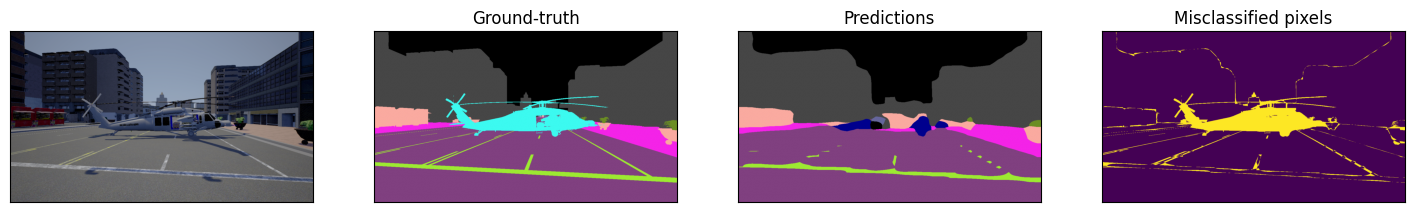

In [42]:
image, labels = __ds_test[1024]
segm_map, ood_scores = predictors_main["kmeans"](image.unsqueeze(0).to(DEVICE))
segm_map = segm_map.cpu().squeeze(0)

plt.figure(figsize=(18, 5))
plt.subplot(1, 4, 1)
visualize_scene(image)
plt.subplot(1, 4, 2)
plt.title("Ground-truth")
visualize_annotation(labels)
plt.subplot(1, 4, 3)
plt.title("Predictions")
visualize_annotation(segm_map)
plt.subplot(1, 4, 4)
plt.title("Misclassified pixels")
plt.imshow(labels != segm_map)
plt.xticks([])
plt.yticks([])
plt.show()

#### <a id='toc1_7_2_2_'></a>[4.2.2. Anomaly segmentation](#toc0_)

Analyzing anomaly maps, it can be seen that there are mostly three cases:
- Maximum softmax probability has visually the most appealing results as it correctly down-weighs non-anomalies. However, it tends to recognize anomalies only partially or miss them.
- MaxLogit and standardized MaxLogit tend to correctly identify anomalous objects but are also more conservative by assigning to most of the scene some degree of anomaly.
- $k$-NN and $k$-means can be located at the middle ground between the previous models. They tend to identify the anomalies and also distinguish "easy non-anomalies".

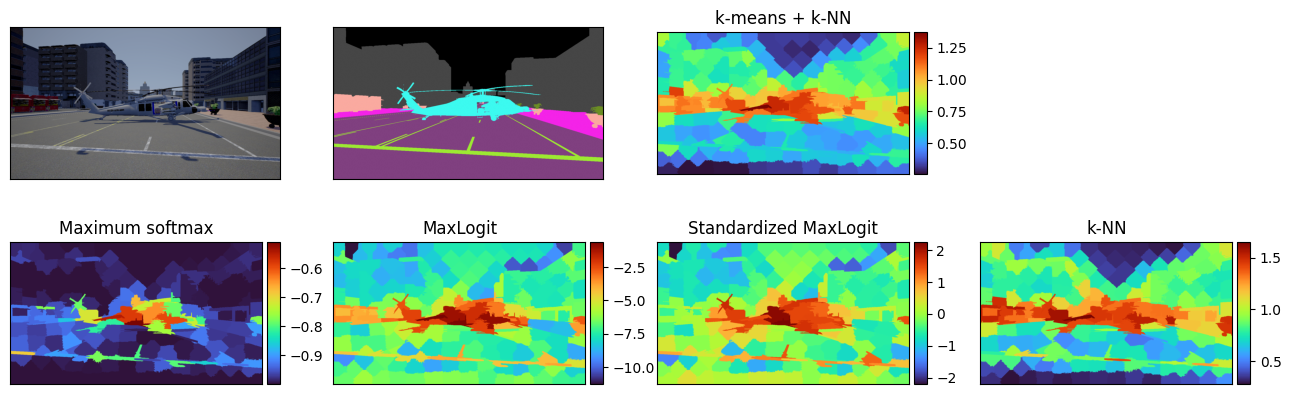

In [39]:
image, labels = __ds_test[1024]
_, ood_scores_maxsoftmax = predictors_main["maxsoftmax"](image.unsqueeze(0).to(DEVICE))
_, ood_scores_maxlogit = predictors_main["maxlogit"](image.unsqueeze(0).to(DEVICE))
_, ood_scores_std_maxlogit = predictors_main["std_maxlogit"](image.unsqueeze(0).to(DEVICE))
_, ood_scores_knn = predictors_main["knn"](image.unsqueeze(0).to(DEVICE))
_, ood_scores_kmeans = predictors_main["kmeans"](image.unsqueeze(0).to(DEVICE))

plt.figure(figsize=(16, 5))
plt.subplot(2, 4, 1)
visualize_scene(image)
plt.subplot(2, 4, 2)
visualize_annotation(labels)
plt.subplot(2, 4, 3)
plt.title("k-means + k-NN")
visualize_anomaly(ood_scores_kmeans.cpu().squeeze(0), colorbar=True)
plt.subplot(2, 4, 5)
plt.title("Maximum softmax")
visualize_anomaly(ood_scores_maxsoftmax.cpu().squeeze(0), colorbar=True)
plt.subplot(2, 4, 6)
plt.title("MaxLogit")
visualize_anomaly(ood_scores_maxlogit.cpu().squeeze(0), colorbar=True)
plt.subplot(2, 4, 7)
plt.title("Standardized MaxLogit")
visualize_anomaly(ood_scores_std_maxlogit.cpu().squeeze(0), colorbar=True)
plt.subplot(2, 4, 8)
plt.title("k-NN")
visualize_anomaly(ood_scores_knn.cpu().squeeze(0), colorbar=True)


---
## <a id='toc1_8_'></a>[5. Ablation study](#toc0_)

This section presents the results of ablation study. The investigation can be divided into two areas:
- Segmentation architecture: check how a different feature extractor affects the results.
- Anomaly detector: check how different choices for the anomaly detector change the results.

Although not ideal, as there is no official validation set that can be used to check the anomaly detector, the test set, alongside the validation set, is used to perform ablation. The artificially created validation set, despite being useful for hyperparameter tuning, is not representative of the real data and is therefore not an ideal candidate to check design choices. However, the findings of this section were not used to tune the model, so the use of the test set can be considered acceptable.

In [40]:
predictors_main = load_predictors(
    segmenter_card = "apple/deeplabv3-mobilevit-small", 
    segmenter_ckp_path = DEEPLABV3_MOBILE_VIT_S_MAIN_DIR, 
    PredictorClass = SuperpixelPredictor, 
    ds_train = ds_train,
    use_prefitted = LOAD_PREFITTED,
    label = "baseline"
)

### <a id='toc1_8_1_'></a>[5.1. Feature extractor](#toc0_)

As DeepLabV3 is a well established architecture, ablation is not needed on its specific architecture. However, the choice of the feature extractor can be questioned. Therefore, this part of ablation study aims to determine whether a different feature extractor would yield significantly different results.

The following new feature extractors have been considered:
- MobileViT-extra-small, which can be seen as a downgrade from the current MobileViT-small.
- MobileNetV3-large, which can be considered as a "side-grade" of MobileViT-small and allows to test a CNN against ViT.

In terms of resources, it can be seen that MobileViT-small is the model with the highest number of FLOPs, while MobileNet is the largest in terms of number of parameters.

In [41]:
# Computed using `calflops`
display(
    pd.DataFrame.from_dict({
        "MobileViT-small": { "GFLOPs": 27.62, "Parameters": "6.36 M" },
        "MobileViT-xsmall": { "GFLOPs": 14.95, "Parameters": "2.94 M" },
        "MobileNet": { "GFLOPs": 19.73, "Parameters": "11.02 M" }
    })
)

MobileViT-small MobileViT-xsmall MobileNet
GFLOPs               27.62            14.95     19.73
Parameters          6.36 M           2.94 M   11.02 M

#### <a id='toc1_8_1_1_'></a>[5.1.1. Smaller model: DeepLabV3 + MobileViT-xsmall](#toc0_)

As expected, a smaller model worsens both in terms of mIoU and AUPR. However, even with half the parameters and FLOPs, it must be noted that results do not drastically fall.

In [42]:
predictors_vitxs = load_predictors(
    segmenter_card = "apple/deeplabv3-mobilevit-x-small", 
    segmenter_ckp_path = DEEPLABV3_MOBILE_VIT_XS_ABL_DIR, 
    PredictorClass = SuperpixelPredictor, 
    ds_train = ds_train,
    use_prefitted = LOAD_PREFITTED,
    label = "MobileViT-xsmall",
    include = ["kmeans"]
)


if RUN_ABLATION:
    all_results["val"]["vit_xs"] = evaluate_segmenter(predictors_vitxs["kmeans"], ds_val, "Segmenter (MobileViT-xsmall)")
    all_results["test"]["vit_xs"] = evaluate_predictors(predictors_vitxs["kmeans"], __ds_test)
else:
    all_results["val"]["vit_xs"] = [{'model': 'Segmenter (MobileViT-xsmall)', 'miou': 0.46382027907744877, 'iou_c': [0.8303561819868517, 0.7804938098604958, 0.28778075168584105, 0.3059484204770593, 0.0023121956019087914, 0.13047976535674125, 0.3909261114262158, 0.9194183592826688, 0.6848642297466878, 0.7748901503408965, 0.33315474044611043, 0.43285382842509446, 0.15618508337026368]}]
    all_results["test"]["vit_xs"] = [{'model': 'k-means + k-NN (MobileViT-xsmall)', 'miou': 0.468057163068401, 'iou_c': [0.8443752299328159, 0.7064970556794696, 0.2934165512089188, 0.22871424767146217, 0.0, 0.15195404290696327, 0.34585935923446154, 0.9371999834299224, 0.6644133184879606, 0.7519029855673055, 0.5802760906137971, 0.4043415237819219, 0.1757927313742159], 'ap': 0.11567296370759796}]


display_results(all_results["val"]["vit_xs"] + all_results["val"]["main"], caption="Results on validation set")
display_results(all_results["test"]["vit_xs"] + [all_results["test"]["main"][-1]], caption="Results on test set")

#### <a id='toc1_8_1_2_'></a>[5.1.2. Bigger model: DeepLabV3 + MobileNet](#toc0_)

By doing a "side-grade", it can be seen that the results on the validation set are mostly the same. Instead, on the test set, MobileNet is worse than MobileViT-small. For anomaly detection, this can be motivated by the fact that the embeddings of MobileNet are of higher dimensionality than MobileViT, making $k$-NN less effective.

In [43]:
predictors_mobilenet = load_predictors(
    segmenter_card = "deeplabv3_mobilenet",
    segmenter_args = { "image_size": (512, 512) },
    segmenter_ckp_path = DEEPLABV3_MOBILENET_ABL_DIR, 
    PredictorClass = SuperpixelPredictor, 
    ds_train = ds_train,
    use_prefitted = LOAD_PREFITTED,
    label = "MobileNet",
    include = ["kmeans"]
)


if RUN_ABLATION:
    all_results["val"]["mobilenet"] = evaluate_segmenter(predictors_mobilenet["kmeans"], ds_val, "Segmenter (MobileNet)")
    all_results["test"]["mobilenet"] = evaluate_predictors(predictors_mobilenet["kmeans"], __ds_test)
else:
    all_results["val"]["mobilenet"] = [{'model': 'Segmenter (MobileNet)', 'miou': 0.5100038284309021, 'iou_c': [0.8510413604016155, 0.7586052679556001, 0.4779438107611545, 0.26917454683405523, 0.35128421447319086, 0.13689385785777358, 0.4332608018179038, 0.9130017353830095, 0.7134673817450011, 0.7667959094521766, 0.43810371031116, 0.36602234377692927, 0.15445482883215603]}]
    all_results["test"]["mobilenet"] = [{'model': 'k-means + k-NN (MobileNet)', 'miou': 0.4544982051120965, 'iou_c': [0.838459975140815, 0.6860042398946746, 0.28844338355956806, 0.17198338516524433, 0.0, 0.1649088078215275, 0.36128659658523704, 0.940330780772812, 0.6788559061848938, 0.7413313741919513, 0.570505535110801, 0.32056426167979735, 0.14580242034993238], 'ap': 0.1096383883294273}]


display_results(all_results["val"]["mobilenet"] + all_results["val"]["main"], caption="Results on validation set")
display_results(all_results["test"]["mobilenet"] + [all_results["test"]["main"][-1]], caption="Results on test set")

#### <a id='toc1_8_1_3_'></a>[5.1.3. Qualitative results](#toc0_)

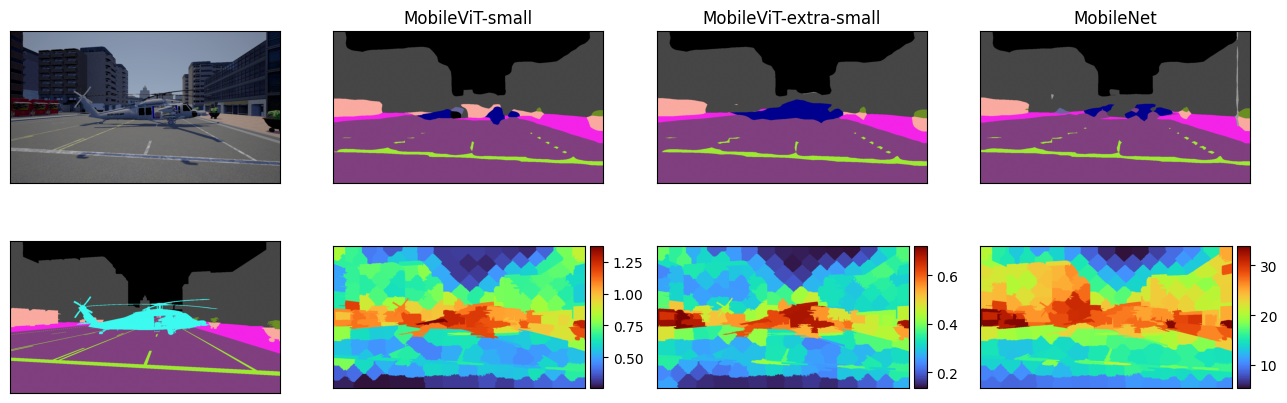

In [44]:
image, labels = __ds_test[1024]
segm_map_main, ood_scores_main = predictors_main["kmeans"](image.unsqueeze(0).to(DEVICE))
segm_map_vitxs, ood_scores_vitxs = predictors_vitxs["kmeans"](image.unsqueeze(0).to(DEVICE))
segm_map_mobilenet, ood_scores_mobilenet = predictors_mobilenet["kmeans"](image.unsqueeze(0).to(DEVICE))

plt.figure(figsize=(16, 5))
plt.subplot(2, 4, 1)
visualize_scene(image)
plt.subplot(2, 4, 5)
visualize_annotation(labels)
plt.subplot(2, 4, 2)
plt.title("MobileViT-small")
visualize_annotation(segm_map_main.cpu().squeeze(0))
plt.subplot(2, 4, 6)
visualize_anomaly(ood_scores_main.cpu().squeeze(0), colorbar=True)
plt.subplot(2, 4, 3)
plt.title("MobileViT-extra-small")
visualize_annotation(segm_map_vitxs.cpu().squeeze(0))
plt.subplot(2, 4, 7)
visualize_anomaly(ood_scores_vitxs.cpu().squeeze(0), colorbar=True)
plt.subplot(2, 4, 4)
plt.title("MobileNet")
visualize_annotation(segm_map_mobilenet.cpu().squeeze(0))
plt.subplot(2, 4, 8)
visualize_anomaly(ood_scores_mobilenet.cpu().squeeze(0), colorbar=True)
plt.show()

### <a id='toc1_8_2_'></a>[5.2. Anomaly detector](#toc0_)

#### <a id='toc1_8_2_1_'></a>[5.2.1. Feature selection](#toc0_)

The choice of the layer from which the embeddings are taken follows the original paper. In this part of ablation study, other layers are assessed. 

Overall, results show that the last layer has the best results, although the others are also closely related in terms of AUPR.

In [45]:
predictors_embeddings2 = load_predictors(
    segmenter_card = "apple/deeplabv3-mobilevit-small", 
    segmenter_ckp_path = DEEPLABV3_MOBILE_VIT_S_MAIN_DIR, 
    PredictorClass = SuperpixelPredictor, 
    ds_train = ds_train,
    use_prefitted = LOAD_PREFITTED,
    hidden_states_index = -2,
    label = "second last embeddings",
    include = ["kmeans"]
)

predictors_embeddings3 = load_predictors(
    segmenter_card = "apple/deeplabv3-mobilevit-small", 
    segmenter_ckp_path = DEEPLABV3_MOBILE_VIT_S_MAIN_DIR, 
    PredictorClass = SuperpixelPredictor, 
    ds_train = ds_train,
    use_prefitted = LOAD_PREFITTED,
    hidden_states_index = -3,
    label = "third last embeddings",
    include = ["kmeans"]
)


if RUN_ABLATION:
    all_results["test"]["embedding2"] = evaluate_predictors(predictors_embeddings2["kmeans"], __ds_test)
    all_results["test"]["embedding3"] = evaluate_predictors(predictors_embeddings3["kmeans"], __ds_test)
else:
    all_results["test"]["embedding2"] = [{'model': 'k-means + k-NN (second last embeddings)', 'miou': 0.48300180341862575, 'iou_c': [0.8473047762474288, 0.708869201459628, 0.2951575984899288, 0.2985249222297859, 0.0, 0.1390436782132098, 0.32976948748853674, 0.9441846006474023, 0.6779678351866865, 0.7598500967899343, 0.5861689755325172, 0.5113235279045996, 0.18085874425247708], 'ap': 0.1273110946311}]
    all_results["test"]["embedding3"] = [{'model': 'k-means + k-NN (third last embeddings)', 'miou': 0.48300180341862575, 'iou_c': [0.8473047762474288, 0.708869201459628, 0.2951575984899288, 0.2985249222297859, 0.0, 0.1390436782132098, 0.32976948748853674, 0.9441846006474023, 0.6779678351866865, 0.7598500967899343, 0.5861689755325172, 0.5113235279045996, 0.18085874425247708], 'ap': 0.13362258345129086}]


display_results(
    [all_results["test"]["main"][-1]] +
    all_results["test"]["embedding2"] + 
    all_results["test"]["embedding3"], 
    caption="Results on test set"
)

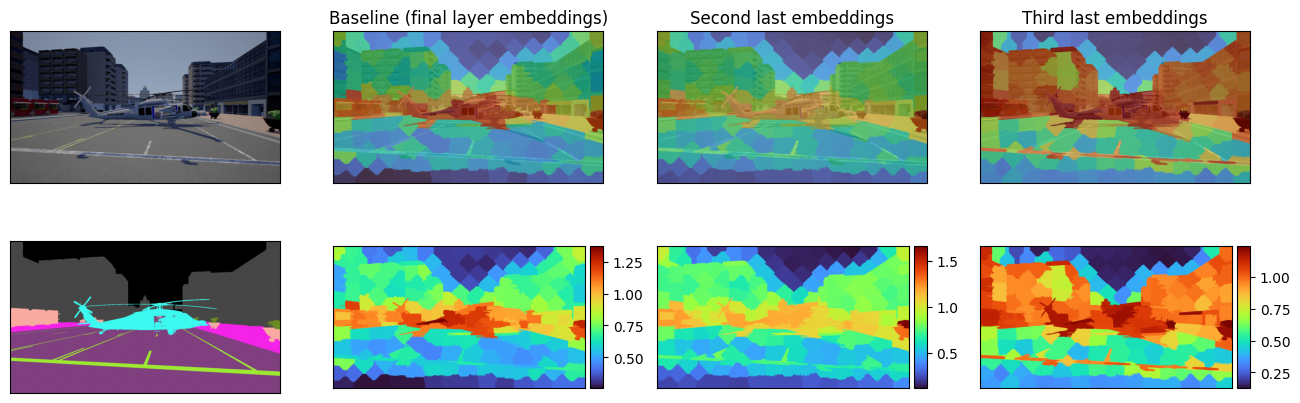

In [46]:
image, labels = __ds_test[1024]
_, ood_scores_main = predictors_main["kmeans"](image.unsqueeze(0).to(DEVICE))
_, ood_scores_embedding2 = predictors_embeddings2["kmeans"](image.unsqueeze(0).to(DEVICE))
_, ood_scores_embedding3 = predictors_embeddings3["kmeans"](image.unsqueeze(0).to(DEVICE))

plt.figure(figsize=(16, 5))
plt.subplot(2, 4, 1)
visualize_scene(image)
plt.subplot(2, 4, 5)
visualize_annotation(labels)
plt.subplot(2, 4, 2)
plt.title("Baseline (final layer embeddings)")
visualize_scene(image)
visualize_anomaly(ood_scores_main.cpu().squeeze(0), alpha=0.6)
plt.subplot(2, 4, 6)
visualize_anomaly(ood_scores_main.cpu().squeeze(0), colorbar=True)
plt.subplot(2, 4, 3)
plt.title("Second last embeddings")
visualize_scene(image)
visualize_anomaly(ood_scores_embedding2.cpu().squeeze(0), alpha=0.6)
plt.subplot(2, 4, 7)
visualize_anomaly(ood_scores_embedding2.cpu().squeeze(0), colorbar=True)
plt.subplot(2, 4, 4)
plt.title("Third last embeddings")
visualize_scene(image)
visualize_anomaly(ood_scores_embedding3.cpu().squeeze(0), alpha=0.6)
plt.subplot(2, 4, 8)
visualize_anomaly(ood_scores_embedding3.cpu().squeeze(0), colorbar=True)
plt.show()

#### <a id='toc1_8_2_2_'></a>[5.2.2. Superpixel segmentation](#toc0_)

This final experiment aims at checking whether post-processing the predictions with superpixel segmentation is actually useful.

As already observed during hyperparameter tuning, adjusting anomaly maps with superpixels allows to align the predictions to the objects in the scene, improving the results both in terms of AUPR and visually.

In [47]:
predictors_no_superpixel = load_predictors(
    segmenter_card = "apple/deeplabv3-mobilevit-small", 
    segmenter_ckp_path = DEEPLABV3_MOBILE_VIT_S_MAIN_DIR, 
    PredictorClass = StandardPredictor, 
    ds_train = ds_train,
    use_prefitted = LOAD_PREFITTED,
    label = "no SLIC"
)


if RUN_ABLATION:
    all_results["test"]["no_superpixel"] = evaluate_predictors(predictors_no_superpixel["kmeans"], __ds_test)
else:
    all_results["test"]["no_superpixel"] = [{'model': 'k-means + k-NN (no SLIC)', 'miou': 0.48300180341862575, 'iou_c': [0.8473047762474288, 0.708869201459628, 0.2951575984899288, 0.2985249222297859, 0.0, 0.1390436782132098, 0.32976948748853674, 0.9441846006474023, 0.6779678351866865, 0.7598500967899343, 0.5861689755325172, 0.5113235279045996, 0.18085874425247708], 'ap': 0.10847552319560197}]


display_results(all_results["test"]["no_superpixel"] + [all_results["test"]["main"][-1]], caption="Results on test set")

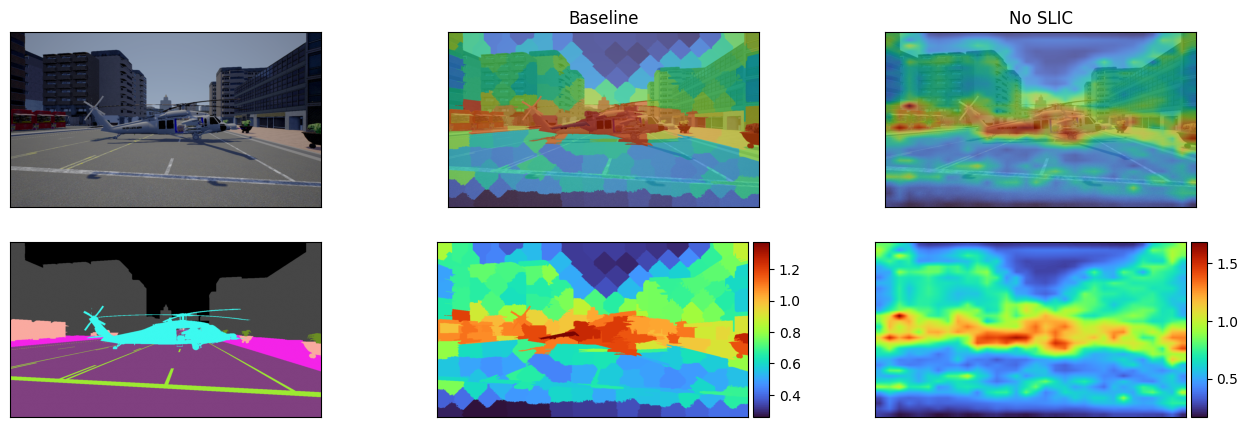

In [48]:
image, labels = __ds_test[1024]
_, ood_scores_main = predictors_main["kmeans"](image.unsqueeze(0).to(DEVICE))
_, ood_scores_no_superpixel = predictors_no_superpixel["kmeans"](image.unsqueeze(0).to(DEVICE))
_, ood_scores_embedding2 = predictors_embeddings2["kmeans"](image.unsqueeze(0).to(DEVICE))
_, ood_scores_embedding3 = predictors_embeddings3["kmeans"](image.unsqueeze(0).to(DEVICE))

plt.figure(figsize=(16, 5))
plt.subplot(2, 3, 1)
visualize_scene(image)
plt.subplot(2, 3, 4)
visualize_annotation(labels)
plt.subplot(2, 3, 2)
plt.title("Baseline")
visualize_scene(image)
visualize_anomaly(ood_scores_main.cpu().squeeze(0), alpha=0.6)
plt.subplot(2, 3, 5)
visualize_anomaly(ood_scores_main.cpu().squeeze(0), colorbar=True)
plt.subplot(2, 3, 3)
plt.title("No SLIC")
visualize_scene(image)
visualize_anomaly(ood_scores_no_superpixel.cpu().squeeze(0), alpha=0.6)
plt.subplot(2, 3, 6)
visualize_anomaly(ood_scores_no_superpixel.cpu().squeeze(0), colorbar=True)
plt.show()

---
## <a id='toc1_9_'></a>[6. Conclusion](#toc0_)

In this assignment, the task of semantic segmentation of unexpected objects on roads has been tackled. The proposed method is based on computing the anomaly map as the distance between the embeddings of the image and its nearest neighbor in a pool of reference embeddings obtained by refining the training embeddings using $k$-means.

To cope with the lack of data for tuning, the hyperparameters of the pipeline have been determined using a validation set with artificially added anomalies. The overall results show that the implemented model improves with respect to using plain $k$-NN. Ablation study found out that the choice of using MobileViT-small as feature extractor allows yielding higher results as its embeddings are more compact. Moreover, it has been seen that using superpixels to align the anomaly map to the content of the scene allows to improve the results. Finally, although not reaching the results of more recent papers, results with smaller architectures allow to show that they are capable of obtaining decent results and outperform some older baselines.

### <a id='toc1_9_1_'></a>[6.1. Discarded approaches](#toc0_)

Just to mention them, the following are some other experiments that are not included in this notebook due to poor results:
- SHE proposed by [Zhang *et al.*](https://openreview.net/forum?id=KkazG4lgKL) based on Hopfield networks. Its low results are most likely due to the fact that, as for standardized MaxLogit, it is highly sensitive to the performance of the segmentation model.
- VT-ADL proposed by [Mishra *et al.*](https://arxiv.org/abs/2104.10036) based on estimating the density of the latent space of an autoencoder using a deep Gaussian mixture model. For this assignment, both the latent of an autoencoder and the embeddings using DeepLabV3+MobileViT-small have been experimented with. Low performance might be explained by the fact that the original work was done on industrial images and a different configuration should be used for this task (e.g., use more Gaussians for GMM, but this would drastically increase the number of parameters).